# Transformer Experiments

building basic decoder-only transformers and experimenting on them  
goal here is lower-level familiarity with transformers beyond fine-tuning or applications, not maximal efficiency or performance  

In [ ]:
from huggingface_hub import login

# login()

/home/jan/miniconda3/envs/torch312/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
!nvidia-smi

Thu Aug 28 18:31:09 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 575.57.04              Driver Version: 576.52         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 5090        On  |   00000000:09:00.0  On |                  N/A |
|  0%   54C    P3             63W /  575W |     956MiB /  32607MiB |     21%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

#### imports

In [2]:
"""
intentionally simple starter decoder-only LLM w/ old school choices like MHA, smol size for iteration (few hundred M ish)
"""
from __future__ import annotations
import math
import os
import sys
import time
import argparse
from dataclasses import dataclass
from typing import Optional
import logging

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import IterableDataset, DataLoader
from transformers import AutoTokenizer, PreTrainedTokenizerBase

import json
from datetime import datetime
from pathlib import Path
from typing import Any, Optional

import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

from torch.utils.data import IterableDataset, DataLoader
from datasets import load_dataset
import torch

logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO, force=True)
logger.setLevel(logging.INFO)

# Ensure a stream handler to stdout
if not any(isinstance(h, logging.StreamHandler) for h in logger.handlers):
    h = logging.StreamHandler(sys.stdout)
    h.setLevel(logging.INFO)
    h.setFormatter(
        logging.Formatter("[%(asctime)s] %(levelname)s %(message)s", "%H:%M:%S")
    )
    logger.addHandler(h)

# Avoid double logging via root if it’s configured differently
logger.propagate = False

logger.info("Logger configured and ready.")

/home/jan/miniconda3/envs/torch312/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[18:31:40] INFO Logger configured and ready.


### Basic decoder-only arch

In [3]:
@dataclass
class Config:
    vocab_size: int = 32_000
    d_model: int = 1_024  # width
    n_heads: int = 16
    n_layers: int = 24
    d_mlp: int = 4_096  # 4x model dim
    max_seq_len: int = 1_024  # context len
    dropout: float = 0.1  # for both attention & MLP layers, will be tuned later
    micro_batch_size: int = 8
    effective_batch_size: int = 512  # accumulate to this size
    token_budget: int = 200_000_000  # 200M good enough for learning purposes
    peak_lr: float = 3e-4
    min_lr_ratio: float = 0.1  # cosine schedule
    warmup_steps: int = 2_000
    betas: tuple[float, float] = (0.9, 0.95)  # for AdamW optimizer
    weight_decay: float = 0.1
    grad_clip: float = 1.0
    use_bf16: bool = True
    log_interval: int = 100
    val_interval: int = 1_000
    val_batches: int = 50
    attn_hist_layers: list[int] = (0, 12, 23)  # histograms
    spm_model_path: Optional[str] = None  # tokenizer
    verbose_logs: bool = True


class HFTokenizerAdapter:
    """
    Thin wrapper over a pretrained HuggingFace tokenizer.
    Includes a bytes-per-token estimator useful for bpb metrics.

    Notes:
    - Word-boundary markers:
        * GPT-2/BPE-style uses "Ġ" for a leading space.
        * SentencePiece uses "▁" for a leading space.
    - Byte-fallback tokens often look like "<0xAB>" and should count as 1 byte.
    """

    def __init__(self, name_or_path: str):
        tok: PreTrainedTokenizerBase = AutoTokenizer.from_pretrained(
            name_or_path,
            use_fast=True,
            trust_remote_code=False,
        )
        self.tok = tok
        self.vocab_size = int(self.tok.vocab_size)
        # Cache for quick checks
        self._special_tokens = set(getattr(self.tok, "all_special_tokens", []))

    def encode(self, text: str) -> list[int]:
        return self.tok.encode(text, add_special_tokens=False)

    def decode(self, ids: list[int]) -> str:
        return self.tok.decode(ids, skip_special_tokens=True)

    def _token_byte_len(self, token_str: str) -> int:
        # Treat leading word-boundary markers as a space (1 byte), then measure the core
        if token_str.startswith("Ġ") or token_str.startswith("▁"):
            core = token_str[1:]
            return 1 + len(core.encode("utf-8"))

        # Byte-fallback style tokens like "<0xAB>" → count as exactly 1 byte
        if (
            len(token_str) >= 5
            and token_str.startswith("<0x")
            and token_str.endswith(">")
        ):
            return 1

        # Special tokens (e.g., <s>, </s>, [PAD]) don't correspond to source bytes; count as 0
        if token_str in self._special_tokens:
            return 0

        # Default: UTF-8 length
        return len(token_str.encode("utf-8"))

    def bytes_per_token(self, ids: torch.Tensor) -> torch.Tensor:
        """
        Map token IDs → token strings → estimated byte lengths.
        Returns a tensor shaped like `ids` (float32) on the same device.
        """
        if not torch.is_tensor(ids):
            raise TypeError(f"`ids` must be a torch.Tensor, got {type(ids)}")

        flat = ids.view(-1).tolist()
        toks = self.tok.convert_ids_to_tokens(flat)
        lens = [self._token_byte_len(t) for t in toks]
        return torch.tensor(lens, dtype=torch.float32, device=ids.device).view_as(ids)


class MultiHeadSelfAttention(nn.Module):
    """
    Vanilla decoder-only MHSA for simplicity, as a starting point.
    - pre-norm
    - dropout
    """

    def __init__(self, d_model: int, n_heads: int, dropout: float, max_seq_len: int):
        super().__init__()
        assert d_model % n_heads == 0, "model dim must be divisible by n heads"
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_head = d_model // n_heads
        self.dropout = nn.Dropout(dropout)

        # Projections from embed dim to QKV
        self.qkv = nn.Linear(d_model, 3 * d_model, bias=True)
        self.out = nn.Linear(d_model, d_model, bias=True)

        # Causal mask
        mask = torch.full((1, 1, max_seq_len, max_seq_len), float("-inf"))
        mask = torch.triu(mask, diagonal=1)
        self.register_buffer("causal_mask", mask, persistent=False)

    def forward(
        self, x: torch.Tensor, need_attn: bool = False
    ) -> tuple[torch.Tensor, Optional[torch.Tensor]]:
        B, T, C = x.size()  # batch, time, channels
        # TODO: B, T, C review

        qkv = self.qkv(x)
        q, k, v = qkv.split(C, dim=-1)

        q = q.view(B, T, self.n_heads, self.d_head).transpose(
            1, 2
        )  # TODO: think about this reshape op
        k = k.view(B, T, self.n_heads, self.d_head).transpose(
            1, 2
        )  # TODO: think about this reshape op
        v = v.view(B, T, self.n_heads, self.d_head).transpose(
            1, 2
        )  # TODO: think about this reshape op

        # scaled dot product attention
        attn_scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(
            self.d_head
        )  # TODO: study this op + transpose
        # causal mask
        attn_scores = attn_scores + self.causal_mask[..., :T, :T]

        # softmax yields probas
        attn_probs = F.softmax(attn_scores, dim=-1)
        attn_probs = self.dropout(attn_probs)

        y = torch.matmul(attn_probs, v)

        # restore to (B, T, C) format
        y = (
            y.transpose(1, 2).contiguous().view(B, T, C)
        )  # TODO: again study the reshape op
        y = self.out(y)

        return (y, attn_probs) if need_attn else (y, None)


class MLP(nn.Module):
    """
    Vanilla feed forward / MLP
    LN -> linear -> GELU -> dropout -> linear -> dropout
    """

    def __init__(self, d_model: int, d_mlp: int, dropout: float):
        super().__init__()
        self.fc1 = nn.Linear(d_model, d_mlp)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(d_mlp, d_model)
        self.drop = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class DecoderBlock(nn.Module):
    """
    simple pre-norm decoder block
    """

    def __init__(
        self, d_model: int, n_heads: int, d_mlp: int, dropout: float, max_seq_len: int
    ):
        super().__init__()
        self.ln1 = nn.LayerNorm(d_model)
        self.attn = MultiHeadSelfAttention(d_model, n_heads, dropout, max_seq_len)
        self.ln2 = nn.LayerNorm(d_model)
        self.mlp = MLP(d_model, d_mlp, dropout)

    def forward(
        self, x: torch.Tensor, need_attn: bool = False
    ) -> tuple[torch.Tensor, Optional[torch.Tensor]]:
        a, attn_probs = self.attn(
            self.ln1(x), need_attn=need_attn
        )  # TODO: uhhh a is the result? and attn_probs?
        x = x + a  # residual connection
        m = self.mlp(self.ln2(x))
        x = x + m  # residual connection
        return x, attn_probs


class DecoderOnlyLM(nn.Module):
    """
    Basic version, GPT-2 style:
    - learned abs. pos. embeddings
    - pre norm
    (GELU, etc.)
    """

    def __init__(self, cfg: Config):
        super().__init__()
        self.cfg = cfg

        self.tok_emb = nn.Embedding(cfg.vocab_size, cfg.d_model)
        self.pos_emb = nn.Embedding(cfg.max_seq_len, cfg.d_model)

        self.blocks = nn.ModuleList(
            [
                DecoderBlock(
                    cfg.d_model, cfg.n_heads, cfg.d_mlp, cfg.dropout, cfg.max_seq_len
                )
                for block in range(cfg.n_layers)
            ]
        )
        self.ln_f = nn.LayerNorm(cfg.d_model)

        # LM head weight tied to tok_emb
        self.lm_head = nn.Linear(cfg.d_model, cfg.vocab_size, bias=False)
        self.lm_head.weight = self.tok_emb.weight  # TODO weight tying???

    def _init_weights(self, module):
        # GPT2 style
        if isinstance(module, (nn.Linear, nn.Embedding)):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if isinstance(module, nn.Linear) and module.bias is not None:
                nn.init.zeros_(module.bias)

    def forward(
        self, idx: torch.Tensor, need_attn_layers: Optional[list[int]] = None
    ) -> tuple[torch.Tensor, dict[int, torch.Tensor]]:
        """
        idx: (B, T) token IDs
        return:
                logits: (B, T, vocab)
                attn_store: dict[layer_idx -> attn_probs (B, H, T, T)] for requested layers
        """
        B, T = idx.size()
        assert T <= self.cfg.max_seq_len, "Context len exceeded"

        positions = torch.arange(0, T, device=idx.device, dtype=torch.long)
        x = self.tok_emb(idx) + self.pos_emb(positions)[None, :, :]  # dims B, T, C
        attn_store: dict[int, torch.Tensor] = dict()
        for layer_idx, block in enumerate(self.blocks):
            need_attn = need_attn_layers is not None and layer_idx in need_attn_layers
            x, attn = block(x, need_attn=need_attn)
            if need_attn and attn is not None:
                attn_store[layer_idx] = attn

        x = self.ln_f(x)
        logits = self.lm_head(x)
        return logits, attn_store

#### training + helper funcs

In [4]:
# Helpers

from gc import enable
from math import cos
from sre_parse import Tokenizer


class WarmupCosineScheduler:
    def __init__(
        self,
        optimizer: torch.optim.Optimizer,
        peak_lr: float,
        warmup_steps: int,
        total_steps: int,
        min_lr_ratio: float = 0.1,
    ):
        self.opt = optimizer
        self.peak_lr = peak_lr
        self.warmup_steps = max(1, warmup_steps)
        self.total_steps = max(warmup_steps + 1, total_steps)
        self.min_lr = peak_lr * min_lr_ratio
        self.step_num = 0
        self._set_lr(0.0)

    def _set_lr(self, lr: float):
        for g in self.opt.param_groups:
            g["lr"] = lr

    def step(self):
        self.step_num += 1
        if self.step_num <= self.warmup_steps:
            lr = self.peak_lr * (self.step_num / self.warmup_steps)
        else:
            progress = (self.step_num - self.warmup_steps) / max(
                1, (self.total_steps - self.warmup_steps)
            )
            # cosine schedule from max to min_lr/peak_lr
            cosine = 0.5 * (1.0 + math.cos(math.pi * progress))
            lr = self.min_lr + (self.peak_lr - self.min_lr) * cosine
        self._set_lr(lr)
        return lr


LOG2E = 1.0 / math.log(2.0)  # nats -> bits


@torch.no_grad()
def evaluate_loss_and_metrics(
    model: DecoderOnlyLM,
    val_loader: DataLoader,
    tokenizer: HFTokenizerAdapter,
    device: torch.device,
    max_batches: int,
    want_attn_hist_layers: list[int],
) -> dict[str, object]:
    """
    compute loss metrics: bits per token, bits per bytes, loss by posn, attention distance hists for some layers
    """
    model.eval()
    ce_sum = 0.0
    tok_count = 0
    byte_loss_sum = 0.0
    byte_count = 0.0

    correct_sum = 0
    total_sum = 0

    pos_loss_sum = None
    pos_count = 0

    attn_hist: dict[int, torch.Tensor] = dict()
    T_max = model.cfg.max_seq_len

    batches = 0
    start = time.time()
    for x, y in val_loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        with torch.autocast(
            device_type=device.type, dtype=torch.bfloat16, enabled=model.cfg.use_bf16
        ):
            logits, attn_store = model(
                x, need_attn_layers=want_attn_hist_layers if batches == 0 else None
            )

        # logits (B, T, V), y: (B, T)
        # compute CE in fp32 for numerical stability
        loss_per_token = F.cross_entropy(
            logits.float().view(-1, logits.size(-1)), y.view(-1), reduction="none"
        ).view_as(y)

        # next-token accuracy
        preds = logits.argmax(dim=-1)
        correct_sum += (preds == y).sum().item()
        total_sum += y.numel()

        ce_sum += loss_per_token.sum().item()
        tok_count += y.numel()

        # bits per byte, only for val
        bptok = tokenizer.bytes_per_token(y)
        byte_loss_sum += (loss_per_token * bptok).sum().item()
        byte_count += bptok.sum().item()

        pos_loss = loss_per_token.float().mean(dim=0)
        if pos_loss_sum is None:
            pos_loss_sum = pos_loss.clone()
        else:
            pos_loss_sum += pos_loss
        pos_count += 1

        # Attention distance histogram
        if batches == 0 and attn_store:
            # For each requested layer, build a histogram over distances 0..T-1
            # distance d = query_pos - key_pos (only k <= q in causal attention)
            for li, attn in attn_store.items():  # attn: (B, H, T, T)
                B, H, T, _ = attn.size()
                # Only the lower triangle is non-zero; build a mask of indices
                # We'll sum attention probs grouped by distance d
                attn = attn[:, :, :T, :T]  # (B,H,T,T)
                # Create an index matrix of distances: dist[q,k] = q - k
                # dist shape (T,T); broadcast to (B,H,T,T) after unsqueeze
                dist = torch.arange(T, device=attn.device).view(T, 1) - torch.arange(
                    T, device=attn.device
                ).view(1, T)
                dist = dist.clamp(min=0)  # ensure causal distances only
                # Flatten to bins 0..T-1
                hist = torch.zeros(T_max, device=attn.device, dtype=torch.float32)
                # Accumulate probs into bins
                for d in range(T):
                    mask = (dist == d).unsqueeze(0).unsqueeze(0)  # (1,1,T,T)
                    mass_d = attn.masked_select(mask).sum()
                    hist[d] = mass_d
                # Normalize to probability distribution
                s = hist.sum()
                if s > 0:
                    hist = hist / s
                attn_hist[li] = hist.detach().cpu()

        batches += 1
        if batches >= max_batches:
            break

    elapsed = time.time() - start
    bpt = (ce_sum / tok_count) * LOG2E
    bpb = (byte_loss_sum / max(1.0, byte_count)) * LOG2E
    loss_by_pos = (
        (pos_loss_sum / pos_count).cpu().tolist() if pos_loss_sum is not None else []
    )

    acc = (correct_sum / max(1, total_sum)) if total_sum > 0 else 0.0

    return dict(
        bits_per_token=bpt,
        bits_per_byte=bpb,
        loss_by_position=loss_by_pos,
        attn_distance_hist={int(k): v.tolist() for k, v in attn_hist.items()},
        eval_time_sec=elapsed,
        tokens_evaluated=int(tok_count),
        accuracy=float(acc),
    )


def compute_param_count(model: nn.Model) -> int:
    return sum(p.numel() for p in model.parameters())


# Training


# def main():
#     parser = argparse.ArgumentParser()
#     parser.add_argument(
#         "--spm_model",
#         type=str,
#         default=None,
#         help="Path to SentencePiece model (optional).",
#     )
#     parser.add_argument(
#         "--device", type=str, default="cuda" if torch.cuda.is_available() else "cpu"
#     )
#     parser.add_argument(
#         "--compile",
#         action="store_true",
#         help="Use torch.compile for model (PyTorch 2.0+).",
#     )
#     parser.add_argument("--micro_bsz", type=int, default=8)
#     parser.add_argument("--eff_bsz", type=int, default=512)
#     parser.add_argument("--tokens", type=int, default=200_000_000)
#     parser.add_argument("--val_every", type=int, default=1000)
#     parser.add_argument("--log_every", type=int, default=100)
#     parser.add_argument("--nih_every", type=int, default=5000)
#     args = parser.parse_args()

#     cfg = Config(
#         spm_model_path=args.spm_model,
#         micro_batch_size=args.micro_bsz,
#         effective_batch_size=args.eff_bsz,
#         token_budget=args.tokens,
#         val_interval=args.val_every,
#         log_interval=args.log_every,
#         nih_eval_interval=args.nih_every,
#     )

#     device = torch.device(args.device)
#     tokenizer = HFTokenizerAdapter(cfg)

#     model = DecoderOnlyLM(cfg).to(device)
#     if args.compile and hasattr(torch, "compile"):
#         model = torch.compile(model, mode="max-autotune")

#     n_params = compute_param_count(model)
#     logger.info(f"Model config: {n_params/1e6:.2f}M | vocab={cfg.vocab_size} | layers={cfg.n_layers} | d={cfg.d_model} | heads={cfg.n_heads}")

#     # Data: for a *real* run, replace RandomTokenStream with your dataset.
#     # Here we provide 2 streams for train/val driven by the token budget.
#     train_tokens = int(cfg.token_budget * 0.98)  # most tokens to training
#     val_tokens = max(cfg.max_seq_len * 1024, int(cfg.token_budget * 0.02))  # enough for stable val
#     train_ds = RandomTokenStream(tokenizer.vocab_size, cfg.max_seq_len, train_tokens)
#     val_ds = RandomTokenStream(tokenizer.vocab_size, cfg.max_seq_len, val_tokens)
#     # FIXME REPLACE W/ REAL STREAMS

#     train_loader = DataLoader(train_ds, batch_size=cfg.micro_batch_sizel, num_workers=0, pin_memory=True)
#     val_loader = DataLoader(val_ds, batch_size=cfg.micro_batch_sizel, num_workers=0, pin_memory=True)

#     # optimizer should not apply to layer norm or embedding biases
#     optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.peak_lr, betas=cfg.betas, weight_decay=cfg.weight_decay)

#     # accumulate micro batches (for memory limitations) into batches
#     grad_accum_steps = max(1, cfg.effective_batch_size // cfg.micro_batch_size)
#     logger.info(f"Gradient accumulation steps: {grad_accum_steps} -> effective batch = {cfg.micro_batch_size * grad_accum_steps}")

#     tokens_per_microbatch = cfg.micro_batch_size * cfg.max_seq_len
#     tokens_per_opt_step = tokens_per_microbatch * grad_accum_steps
#     total_opt_steps = max(1, cfg.token_budget // tokens_per_opt_step)
#     print(f"Planned optimizer steps: {total_opt_steps} | tokens/step = {tokens_per_opt_step} | total tokens ~ {total_opt_steps * tokens_per_opt_step:,}")")

#     scheduler = WarmupCosineScheduler(
#         optimizer=optimizer,
#         peak_lr=cfg.peak_lr,
#         warmup_steps=cfg.warmup_steps,
#         total_steps=total_opt_steps,
#         min_lr_ratio=cfg.min_lr_ratio,
#     )

#     use_amp = (device.type == "cuda") and cfg.use_bf16

#     # Training state
#     step = 0
#     token_counter = 0
#     running_loss = 0.0
#     running_tokens = 0
#     t0 = time.time()

#     # For each optimizer step, we need grad_accum_steps micro-batches
#     micro_iter = iter(train_loader)

#     while step < total_opt_steps:
#         optimizer.zero_grad(set_to_none=True)

#         for micro in range(grad_accum_steps):
#             try:
#                 x, y = next(micro_iter)
#             except StopIteration:
#                 logger.debug("Had to replenish dataset")
#                 micro_iter = iter(train_loader)
#                 x, y = next(micro_iter)

#         x = x.to(device, non_blocking=True)
#         y = y.to(device, non_blocking=True)

#         with torch.autocast(device_type=device.type, dtype=torch.bfloat16, enabled=use_amp):
#             logits, _ = model(x, need_attn_layers=None)
#             loss = F.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1))

#         (loss / grad_accum_steps).backward()  # normalize by accum steps
#         running_loss += loss.item() * x.size(0) * x.size(1)
#         running_tokens += x.numel()
#         token_counter += x.numel()


#     total_norm = torhc.nn.utils.clip_grad_norm_(model.parameters(), cfg.grad_clip).item()
#     optimizer.step()
#     lr_now = scheduler.step()
#     step += 1

#     # Progress logging
#     if step % cfg.log_interval == 0 or step == 1:
#         elapsed = time.time() - t0
#         tok_per_sec = running_tokens / max(1e-9, elapsed)
#         bits_per_token = (running_loss / max(1, running_tokens)) * LOG2E
#         logger.info(
#             f"[step {step:6d}/{total_opt_steps}] "
#             f"lr={lr_now:.5f}  "
#             f"bpt(train)={bits_per_token:.3f}  "
#             f"gnorm={total_norm:.3f}  "
#             f"tok/s={tok_per_sec:,.0f}  "
#             f"tokens_done={token_counter:,}"
#         )
#         # reset running stats window
#         running_loss = 0.0
#         running_tokens = 0
#         t0 = time.time()

#     # Val
#     if step % cfg.val_interval == 0 or step == total_opt_steps:
#             metrics = evaluate_loss_and_metrics(
#                 model=model,
#                 val_loader=val_loader,
#                 tokenizer=tokenizer,
#                 device=device,
#                 max_batches=cfg.val_batches,
#                 want_attn_hist_layers=list(cfg.attn_hist_layers),
#             )
#             print(f"[val @ step {step}] "
#                   f"bpt={metrics['bits_per_token']:.3f}  "
#                   f"bpb={metrics['bits_per_byte']:.3f}  "
#                   f"eval_tokens={metrics['tokens_evaluated']:,}  "
#                   f"eval_time={metrics['eval_time_sec']:.2f}s")
#             # Loss-by-position preview (first 16 positions)
#             lbp = metrics["loss_by_position"]
#             if isinstance(lbp, list) and len(lbp) > 0:
#                 preview = ", ".join(f"{(v*LOG2E):.2f}" for v in lbp[:16])  # convert nats->bits for display
#                 print(f"  loss-by-position(bits) first 16: [{preview} ...]")
#             # Attention histograms (distance distribution)
#             adh = metrics["attn_distance_hist"]
#             if isinstance(adh, dict) and len(adh) > 0:
#                 for li in sorted(adh.keys()):
#                     # summarize with mean distance (expected lag)
#                     hist = torch.tensor(adh[li], dtype=torch.float32)
#                     distances = torch.arange(len(hist), dtype=torch.float32)
#                     exp_dist = float((hist * distances).sum().item())
#                     print(f"  attn-distance layer {li:02d}: E[distance]={exp_dist:.1f}")

#     logger.info("Training complete.")

/tmp/ipykernel_23098/3899650462.py:5: DeprecationWarning: module 'sre_parse' is deprecated
  from sre_parse import Tokenizer


In [5]:
# --- Simple Wikipedia -> (x, y) data pipeline (streaming, packed windows) ---


class WikipediaPackedDataset(IterableDataset):
    """
    Stream Wikipedia text and pack contiguous token ids into (x, y) windows of length T
    without padding. This is intentionally simple and robust.

    - Uses HF Hub repo 'wikimedia/wikipedia' (e.g., config='20220301.en'); split is 'train' only.
    - Tokenizer must have .encode(text) -> list[int]
    - Emits infinite stream; your training loop controls total tokens via token_budget.
    """

    def __init__(self, tokenizer, seq_len: int, config: str = "20220301.en"):
        super().__init__()
        self.tok = tokenizer
        self.T = seq_len
        self.config = config  # e.g., '20220301.en' (English snapshot)

    def __iter__(self):
        # Streaming dataset: yields dicts with a 'text' field.
        ds = load_dataset(
            "wikimedia/wikipedia", self.config, split="train", streaming=True
        )
        buf = []  # rolling token buffer; we pack fixed-length windows from here

        for row in ds:
            text = row.get("text", "")
            if not text:
                continue

            ids = self.tok.encode(
                text
            )  # no special tokens; your adapter already does that
            if not ids:
                continue

            buf.extend(ids)

            # Emit as many windows as possible: [t0..tT] -> x=t0..tT-1, y=t1..tT
            while len(buf) >= (self.T + 1):
                chunk = buf[: self.T + 1]
                del buf[: self.T + 1]
                x = torch.tensor(chunk[:-1], dtype=torch.long)
                y = torch.tensor(chunk[1:], dtype=torch.long)
                yield x, y


def make_wikipedia_loaders(
    tokenizer,
    seq_len: int,
    micro_bsz: int,
    config: str = "20220301.en",
    num_workers: int = 0,
    pin_memory: bool = True,
):
    """
    Build train/val DataLoaders. Wikipedia has only 'train', so we create two
    independent streaming iterators over the same snapshot for train and val.
    """
    train_ds = WikipediaPackedDataset(tokenizer, seq_len=seq_len, config=config)
    val_ds = WikipediaPackedDataset(tokenizer, seq_len=seq_len, config=config)

    train_loader = DataLoader(
        train_ds, batch_size=micro_bsz, num_workers=num_workers, pin_memory=pin_memory
    )
    val_loader = DataLoader(
        val_ds, batch_size=micro_bsz, num_workers=num_workers, pin_memory=pin_memory
    )
    return train_loader, val_loader

_plenty of room to refactor and clean up above_

## Run training (initial gpt-2 style model)

In [ ]:
# Configs

cfg = Config(
    vocab_size=0,  # set after loading tokenizer
    d_model=768,  # should try 1024, 12, 24, 4096 MLP or similar later
    n_heads=8,
    n_layers=12,
    d_mlp=2_048,
    max_seq_len=512,
    dropout=0.1,
    micro_batch_size=32,  # 8–16
    effective_batch_size=512,  # via grad accumulation
    token_budget=300_000_000,  # 200M+ later
    peak_lr=3e-4,
    min_lr_ratio=0.10,
    warmup_steps=500,  # short warmup for small runs; increase for long training
    betas=(0.9, 0.95),
    weight_decay=0.10,
    grad_clip=1.0,
    use_bf16=True,
    log_interval=25,  # can increase to e.g. 10's + 100's later
    val_interval=100,
    val_batches=50,
    attn_hist_layers=[0, 4, 7],  # later 0, 12, 23
)

WIKIPEDIA_VERSION = "20231101.en"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# just using the tokenizer. using gpt2 tokenizer for its smaller ~50k vocab size (smaller logits in memory)
tokenizer = HFTokenizerAdapter("openai-community/gpt2")  # ("meta-llama/Llama-3.1-8B")
cfg.vocab_size = tokenizer.vocab_size
logger.info(f"Tokenizer vocab_size: {tokenizer.vocab_size}")
logger.info(f"cfg.vocab_size: {cfg.vocab_size}")

model = DecoderOnlyLM(cfg).to(device)
logger.info(
    f"Params: {sum(p.numel() for p in model.parameters()) / 1e6:.2f}M | V={cfg.vocab_size}"
)

# Optional torch.compile in a notebook (safe to leave off initially)
USE_COMPILE = False
if USE_COMPILE and hasattr(torch, "compile"):
    model = torch.compile(model, mode="max-autotune")

# just using wikipedia for simplicity
train_loader, val_loader = make_wikipedia_loaders(
    tokenizer=tokenizer,
    seq_len=cfg.max_seq_len,
    micro_bsz=cfg.micro_batch_size,
    config=WIKIPEDIA_VERSION,
)

optimizer = torch.optim.AdamW(
    model.parameters(), lr=cfg.peak_lr, betas=cfg.betas, weight_decay=cfg.weight_decay
)

grad_accum_steps = max(1, cfg.effective_batch_size // cfg.micro_batch_size)
tokens_per_microbatch = cfg.micro_batch_size * cfg.max_seq_len
tokens_per_step = tokens_per_microbatch * grad_accum_steps
total_opt_steps = max(1, cfg.token_budget // tokens_per_step)

scheduler = WarmupCosineScheduler(
    optimizer=optimizer,
    peak_lr=cfg.peak_lr,
    warmup_steps=cfg.warmup_steps,
    total_steps=total_opt_steps,
    min_lr_ratio=cfg.min_lr_ratio,
)

logger.info(
    f"Grad-accum: {grad_accum_steps}  tokens/step: {tokens_per_step:,}  planned steps: {total_opt_steps}"
)

[18:36:03] INFO Tokenizer vocab_size: 50257
[18:36:03] INFO cfg.vocab_size: 50257
[18:36:04] INFO Params: 105.16M | V=50257
[18:36:04] INFO Grad-accum: 16  tokens/step: 262,144  planned steps: 762


In [13]:
# training loop


def train_one_run(
    model,
    cfg,
    tokenizer,
    train_loader,
    val_loader,
    optimizer,
    scheduler,
    device,
    logger=None,
    *,
    grad_accum_steps: int | None = None,
    total_opt_steps: int | None = None,
    use_progress: bool = True,
    progress_micro: bool = False,
    progress_desc: str = "train",
):
    """
    Training loop

    Returns a summary dict with final step, tokens processed, last LR/grad-norm, and last val metrics.
    """
    logger.info("Begin training run")

    # Infer accumulation / total steps if not provided
    if grad_accum_steps is None:
        grad_accum_steps = max(1, cfg.effective_batch_size // cfg.micro_batch_size)

    if total_opt_steps is None:
        tokens_per_microbatch = cfg.micro_batch_size * cfg.max_seq_len
        tokens_per_step = tokens_per_microbatch * grad_accum_steps
        total_opt_steps = max(1, cfg.token_budget // tokens_per_step)

    if device.type != "cuda":
        logger.warning("Not running CUDA!")
    use_amp = (device.type == "cuda") and getattr(cfg, "use_bf16", False)
    logger.info(f"Use amp: {use_amp}")

    step = 0
    token_counter = 0
    running_loss_tensor = torch.zeros((), device=device)  # sum of CE (nats) over tokens
    running_tokens = 0
    running_correct_tensor = torch.zeros((), device=device)
    t0 = time.time()
    last_val_metrics = {}
    history = {"train": [], "val": []}

    micro_iter = iter(train_loader)
    model.train()

    # Startup summary (concise)
    if logger and getattr(cfg, "verbose_logs", True):
        try:
            n_params = sum(p.numel() for p in model.parameters())
        except Exception:
            n_params = -1
        dtype = "bf16" if use_amp else "fp32"
        logger.info(
            f"Startup | params={n_params / 1e6:.2f}M | layers={cfg.n_layers} | d={cfg.d_model} | heads={cfg.n_heads} | T={cfg.max_seq_len} | micro_bsz={cfg.micro_batch_size} | eff_bsz={cfg.effective_batch_size} | accum={grad_accum_steps} | device={device.type} | dtype={dtype}"
        )

    # Trackers
    best_bpt = float("inf")
    best_step = None
    logged_warmup_end = False
    log_snapshots = 0
    clipped_logs = 0

    # Progress bar (optional)
    _bar = None
    if use_progress:
        try:
            _bar = tqdm(
                total=total_opt_steps,
                initial=step,
                desc=progress_desc,
                dynamic_ncols=True,
                leave=True,
            )
        except Exception:
            _bar = None
            if logger:
                logger.warning("tqdm progress disabled (init failed)")
    last_postfix = {}

    while step < total_opt_steps:
        optimizer.zero_grad(set_to_none=True)

        # --- accumulate gradients over micro-batches ---
        _micro = None
        if progress_micro and _bar is not None:
            try:
                _micro = tqdm(
                    total=grad_accum_steps,
                    leave=False,
                    desc="accum",
                    dynamic_ncols=True,
                )
            except Exception:
                _micro = None
        for micro_idx in range(grad_accum_steps):
            try:
                x, y = next(micro_iter)
            except StopIteration:
                micro_iter = iter(train_loader)
                x, y = next(micro_iter)

            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)

            # Reset peak memory stats for the very first micro-batch to measure accurately
            if device.type == "cuda" and step == 0 and micro_idx == 0:
                torch.cuda.reset_peak_memory_stats()

            with torch.autocast(
                device_type=device.type, dtype=torch.bfloat16, enabled=use_amp
            ):
                logits, _ = model(x, need_attn_layers=None)
                # compute CE in fp32 for numerical stability
                loss = F.cross_entropy(
                    logits.float().view(-1, logits.size(-1)), y.view(-1)
                )  # nats
                preds = logits.argmax(dim=-1)

            # Memory after logits (first micro-batch only)
            if device.type == "cuda" and step == 0 and micro_idx == 0:
                alloc = torch.cuda.memory_allocated() / 1e9
                max_alloc = torch.cuda.max_memory_allocated() / 1e9
                try:
                    shape = tuple(logits.shape)
                except Exception:
                    shape = "unknown"
                logger.info(
                    f"[mem] after logits: alloc={alloc:.2f} GB, max={max_alloc:.2f} GB, logits={shape}, dtype={logits.dtype}"
                )

            (loss / grad_accum_steps).backward()

            if _micro is not None:
                _micro.update(1)
            # Memory after backward (first micro-batch only)
            if device.type == "cuda" and step == 0 and micro_idx == 0:
                alloc2 = torch.cuda.memory_allocated() / 1e9
                max_alloc2 = torch.cuda.max_memory_allocated() / 1e9
                logger.info(
                    f"[mem] after backward: alloc={alloc2:.2f} GB, max={max_alloc2:.2f} GB"
                )

            running_loss_tensor += loss.detach() * x.numel()
            running_tokens += x.numel()
            running_correct_tensor += (preds == y).sum()
            token_counter += x.numel()

        # --- step: clip, update, schedule ---
        pre_clip_gnorm = float(
            torch.nn.utils.clip_grad_norm_(model.parameters(), cfg.grad_clip)
        )
        optimizer.step()
        lr_now = scheduler.step()
        step += 1

        # Close micro progress for this step
        if _micro is not None:
            try:
                _micro.close()
            except Exception:
                pass

        # Update step progress
        if _bar is not None:
            try:
                _bar.update(1)
                last_postfix = {"lr": f"{lr_now:.2e}"}
                _bar.set_postfix(last_postfix, refresh=False)
            except Exception:
                pass

        # Warmup milestone
        if (not logged_warmup_end) and getattr(cfg, "verbose_logs", True):
            try:
                if (
                    hasattr(scheduler, "step_num")
                    and hasattr(scheduler, "warmup_steps")
                    and scheduler.step_num == scheduler.warmup_steps
                ):
                    logger.info(f"Warmup complete at step {step}: lr={lr_now:.2e}")
                    logged_warmup_end = True
            except Exception:
                pass

        # --- logs ---
        if step % cfg.log_interval == 0 or step == 1:
            elapsed = time.time() - t0
            tok_per_sec = running_tokens / max(1e-9, elapsed)
            bpt_bits = float(
                ((running_loss_tensor / max(1, running_tokens)) * LOG2E).item()
            )
            acc_train = float((running_correct_tensor / max(1, running_tokens)).item())
            ppl_train = float(2.0**bpt_bits) if bpt_bits == bpt_bits else float("nan")
            log_snapshots += 1
            if pre_clip_gnorm > cfg.grad_clip:
                clipped_logs += 1
            clip_rate = clipped_logs / max(1, log_snapshots)
            logger.info(
                f"[step {step:6d}/{total_opt_steps}] "
                f"lr={lr_now:.2e}  "
                f"bpt(train)={bpt_bits:.3f}  "
                f"ppl(train)={ppl_train:.1f}  "
                f"gnorm(pre)={pre_clip_gnorm:.3f}  "
                f"tok/s={tok_per_sec:,.0f}  "
                f"tokens_done={token_counter:,}  "
                f"clip_rate={clip_rate:.2%}"
            )
            # history snapshot
            history["train"].append(
                {
                    "step": int(step),
                    "lr": float(lr_now),
                    "gnorm_pre": float(pre_clip_gnorm),
                    "bpt_train": float(bpt_bits),
                    "acc_train": float(acc_train),
                    "tok_per_sec": float(tok_per_sec),
                    "tokens_done": int(token_counter),
                    "clipped": bool(pre_clip_gnorm > cfg.grad_clip),
                }
            )
            running_loss_tensor.zero_()
            running_correct_tensor.zero_()
            running_tokens = 0
            t0 = time.time()

            # update bar postfix with latest snapshot
            if _bar is not None:
                try:
                    last_postfix = {
                        "lr": f"{lr_now:.2e}",
                        "bpt": f"{bpt_bits:.2f}",
                        "tok_s": f"{tok_per_sec:,.0f}",
                        "clip": f"{clip_rate:.0%}",
                    }
                    _bar.set_postfix(last_postfix, refresh=False)
                except Exception:
                    pass

        # --- validation ---
        if step % cfg.val_interval == 0 or step == total_opt_steps:
            if _bar is not None:
                try:
                    _bar.refresh()
                except Exception:
                    pass
            model.eval()
            last_val_metrics = evaluate_loss_and_metrics(
                model=model,
                val_loader=val_loader,
                tokenizer=tokenizer,
                device=device,
                max_batches=cfg.val_batches,
                want_attn_hist_layers=list(cfg.attn_hist_layers),
            )
            logger.info(
                f"[val @ step {step}] "
                f"bpt={last_val_metrics['bits_per_token']:.3f}  "
                f"bpb={last_val_metrics['bits_per_byte']:.3f}  "
                f"eval_tokens={last_val_metrics['tokens_evaluated']:,}  "
                f"eval_time={last_val_metrics['eval_time_sec']:.2f}s"
            )

            # preview of loss-by-position (first 16 positions) in *bits*
            lbp = last_val_metrics.get("loss_by_position", [])
            if lbp:
                preview = ", ".join(f"{(v * LOG2E):.2f}" for v in lbp[:16])
                logger.info(f"  loss-by-position(bits) first 16: [{preview} ...]")

            # attention distance histograms summary (expected distance)
            adh = last_val_metrics.get("attn_distance_hist", {})
            if adh:
                # adh may have int or str keys depending on serialization
                try_keys = sorted({int(k) for k in adh.keys()})
                for li in try_keys:
                    hist_list = adh.get(li, None) or adh.get(str(li), None)
                    hist = torch.tensor(hist_list, dtype=torch.float32)
                    distances = torch.arange(len(hist), dtype=torch.float32)
                    exp_dist = float((hist * distances).sum().item())
                    logger.info(
                        f"  attn-distance layer {li:02d}: E[distance]={exp_dist:.1f}"
                    )
            # history val snapshot
            val_rec = {
                "step": int(step),
                "bits_per_token": float(
                    last_val_metrics.get("bits_per_token", float("nan"))
                ),
                "bits_per_byte": float(
                    last_val_metrics.get("bits_per_byte", float("nan"))
                ),
                "accuracy": float(last_val_metrics.get("accuracy", float("nan"))),
                "tokens_evaluated": int(last_val_metrics.get("tokens_evaluated", 0)),
            }
            history["val"].append(val_rec)

            model.train()

    logger.info("Training complete.")

    # close progress bar if used
    try:
        _bar.close() if "_bar" in locals() and _bar is not None else None
    except Exception:
        pass

    # persist history to disk
    try:
        from pathlib import Path as _Path
        from datetime import datetime as _Datetime
        import json as _json
        import csv as _csv

        _art = _Path("artifacts")
        _art.mkdir(parents=True, exist_ok=True)
        _ts = _Datetime.now().strftime("%Y%m%d-%H%M%S")
        train_csv = _art / f"train_metrics-{_ts}.csv"
        if history["train"]:
            keys = [
                "step",
                "lr",
                "gnorm_pre",
                "bpt_train",
                "acc_train",
                "tok_per_sec",
                "tokens_done",
                "clipped",
            ]
            with open(train_csv, "w", newline="") as f:
                w = _csv.DictWriter(f, fieldnames=keys)
                w.writeheader()
                for row in history["train"]:
                    w.writerow({k: row.get(k, "") for k in keys})
        val_jsonl = _art / f"val_metrics-{_ts}.jsonl"
        if history["val"]:
            with open(val_jsonl, "w") as f:
                for row in history["val"]:
                    f.write(_json.dumps(row) + " ")
    except Exception as _e:
        if logger:
            logger.warning(f"failed to persist history: {_e}")
        train_csv = None
        val_jsonl = None

    return {
        "final_step": step,
        "tokens_processed": token_counter,
        "last_lr": lr_now,
        "last_grad_norm": pre_clip_gnorm,
        "last_val_metrics": last_val_metrics,
        "grad_accum_steps": grad_accum_steps,
        "total_opt_steps": total_opt_steps,
        "history": history,
        "artifacts": {
            "train_csv": str(train_csv)
            if "train_csv" in locals() and train_csv is not None
            else None,
            "val_jsonl": str(val_jsonl)
            if "val_jsonl" in locals() and val_jsonl is not None
            else None,
        },
    }

In [14]:
summary = train_one_run(
    model,
    cfg,
    tokenizer,
    train_loader,
    val_loader,
    optimizer,
    scheduler,
    device,
    logger,
)

[18:36:12] INFO Begin training run
[18:36:12] INFO Use amp: True
[18:36:12] INFO Startup | params=105.16M | layers=12 | d=768 | heads=8 | T=512 | micro_bsz=32 | eff_bsz=512 | accum=16 | device=cuda | dtype=bf16


train:   0%|          | 0/762 [00:00<?, ?it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (8668 > 1024). Running this sequence through the model will result in indexing errors


[18:36:14] INFO [mem] after logits: alloc=16.52 GB, max=19.81 GB, logits=(32, 512, 50257), dtype=torch.bfloat16
[18:36:14] INFO [mem] after backward: alloc=2.53 GB, max=23.11 GB


train:   0%|          | 1/762 [00:05<1:04:14,  5.06s/it]

[18:36:17] INFO [step      1/762] lr=3.00e-05  bpt(train)=666.157  ppl(train)=341477539818196864113372904882733584657098552464231533363371150640535551906497598587064206116570967999118549088960490598608778417177776970965164906671694175229447537400454916422201699266229522684444672.0  gnorm(pre)=82.046  tok/s=51,724  tokens_done=262,144  clip_rate=100.00%


train:   1%|          | 5/762 [00:17<40:35,  3.22s/it, lr=1.20e-04]                                     

[18:36:29] INFO [step      5/762] lr=1.50e-04  bpt(train)=590.873  ppl(train)=7420569638639405375242273751323023056665240948793295110274888317591248489649780107612770579491427544875798605325605094430808208385448812882809928579176776237683006571450388709376.0  gnorm(pre)=252.352  tok/s=86,163  tokens_done=1,310,720  clip_rate=100.00%


train:   1%|▏         | 10/762 [00:32<38:00,  3.03s/it, lr=2.70e-04]                                    

[18:36:44] INFO Warmup complete at step 10: lr=3.00e-04
[18:36:44] INFO [step     10/762] lr=3.00e-04  bpt(train)=184.960  ppl(train)=47690001789227847563632480733323250620466665568889470976.0  gnorm(pre)=54.625  tok/s=86,965  tokens_done=2,621,440  clip_rate=100.00%


train:   2%|▏         | 15/762 [00:47<37:12,  2.99s/it, lr=3.00e-04]                                     

[18:36:59] INFO [step     15/762] lr=3.00e-04  bpt(train)=99.924  ppl(train)=1202609603033876515820757057536.0  gnorm(pre)=25.045  tok/s=87,097  tokens_done=3,932,160  clip_rate=100.00%


train:   3%|▎         | 20/762 [01:02<36:37,  2.96s/it, lr=3.00e-04]                                    

[18:37:14] INFO [step     20/762] lr=3.00e-04  bpt(train)=86.354  ppl(train)=98880572290775269173624832.0  gnorm(pre)=18.975  tok/s=88,254  tokens_done=5,242,880  clip_rate=100.00%


train:   3%|▎         | 25/762 [01:17<36:27,  2.97s/it, lr=3.00e-04]                                    

[18:37:29] INFO [step     25/762] lr=3.00e-04  bpt(train)=79.049  ppl(train)=625330667491735424204800.0  gnorm(pre)=25.540  tok/s=87,952  tokens_done=6,553,600  clip_rate=100.00%


train:   4%|▍         | 30/762 [01:32<36:43,  3.01s/it, lr=3.00e-04]                                    

[18:37:44] INFO [step     30/762] lr=3.00e-04  bpt(train)=75.272  ppl(train)=45628766957601925627904.0  gnorm(pre)=11.389  tok/s=86,302  tokens_done=7,864,320  clip_rate=100.00%


train:   5%|▍         | 35/762 [01:47<36:59,  3.05s/it, lr=2.99e-04]                                    

[18:37:59] INFO [step     35/762] lr=2.99e-04  bpt(train)=70.763  ppl(train)=2003430341476644552704.0  gnorm(pre)=14.185  tok/s=86,157  tokens_done=9,175,040  clip_rate=100.00%


train:   5%|▌         | 40/762 [02:02<36:52,  3.06s/it, lr=2.99e-04]                                    

[18:38:15] INFO [step     40/762] lr=2.99e-04  bpt(train)=66.972  ppl(train)=144784909935101034496.0  gnorm(pre)=16.150  tok/s=85,579  tokens_done=10,485,760  clip_rate=100.00%


train:   6%|▌         | 45/762 [02:18<36:07,  3.02s/it, lr=2.99e-04]                                    

[18:38:30] INFO [step     45/762] lr=2.99e-04  bpt(train)=65.009  ppl(train)=37132480383351521280.0  gnorm(pre)=28.978  tok/s=86,563  tokens_done=11,796,480  clip_rate=100.00%


train:   7%|▋         | 50/762 [02:33<35:55,  3.03s/it, lr=2.98e-04]                                    

[18:38:45] INFO [step     50/762] lr=2.98e-04  bpt(train)=62.635  ppl(train)=7161937029669519360.0  gnorm(pre)=25.512  tok/s=87,032  tokens_done=13,107,200  clip_rate=100.00%


train:   7%|▋         | 50/762 [02:33<35:55,  3.03s/it, lr=2.98e-04, bpt=62.64, tok_s=87,032, clip=100%]

[18:38:53] INFO [val @ step 50] bpt=60.145  bpb=72.347  eval_tokens=819,200  eval_time=8.46s
[18:38:53] INFO   loss-by-position(bits) first 16: [62.52, 60.59, 58.52, 61.43, 62.62, 60.56, 60.26, 60.85, 61.23, 60.76, 59.81, 61.05, 59.85, 59.47, 60.97, 60.44 ...]
[18:38:53] INFO   attn-distance layer 00: E[distance]=127.9
[18:38:53] INFO   attn-distance layer 04: E[distance]=129.8
[18:38:53] INFO   attn-distance layer 07: E[distance]=128.6


train:   7%|▋         | 55/762 [02:56<42:15,  3.59s/it, lr=2.98e-04]                                      

[18:39:08] INFO [step     55/762] lr=2.98e-04  bpt(train)=60.440  ppl(train)=1563969968445752064.0  gnorm(pre)=12.029  tok/s=56,053  tokens_done=14,417,920  clip_rate=100.00%


train:   8%|▊         | 60/762 [03:11<36:15,  3.10s/it, lr=2.97e-04]                                    

[18:39:23] INFO [step     60/762] lr=2.97e-04  bpt(train)=58.684  ppl(train)=462928515964179008.0  gnorm(pre)=15.685  tok/s=87,286  tokens_done=15,728,640  clip_rate=100.00%


train:   9%|▊         | 65/762 [03:26<34:39,  2.98s/it, lr=2.97e-04]                                    

[18:39:38] INFO [step     65/762] lr=2.96e-04  bpt(train)=57.051  ppl(train)=149284530196712128.0  gnorm(pre)=42.514  tok/s=87,823  tokens_done=17,039,360  clip_rate=100.00%


train:   9%|▉         | 70/762 [03:41<34:17,  2.97s/it, lr=2.96e-04]                                    

[18:39:53] INFO [step     70/762] lr=2.96e-04  bpt(train)=55.073  ppl(train)=37906220854610072.0  gnorm(pre)=8.037  tok/s=87,789  tokens_done=18,350,080  clip_rate=100.00%


train:  10%|▉         | 75/762 [03:56<34:06,  2.98s/it, lr=2.95e-04]                                    

[18:40:08] INFO [step     75/762] lr=2.95e-04  bpt(train)=53.875  ppl(train)=16524300162625494.0  gnorm(pre)=8.190  tok/s=87,731  tokens_done=19,660,800  clip_rate=100.00%


train:  10%|█         | 80/762 [04:10<32:12,  2.83s/it, lr=2.94e-04]                                    

[18:40:22] INFO [step     80/762] lr=2.94e-04  bpt(train)=52.118  ppl(train)=4887632548617735.0  gnorm(pre)=8.003  tok/s=92,314  tokens_done=20,971,520  clip_rate=100.00%


train:  11%|█         | 85/762 [04:24<31:22,  2.78s/it, lr=2.94e-04]                                    

[18:40:36] INFO [step     85/762] lr=2.93e-04  bpt(train)=50.813  ppl(train)=1977609895743442.2  gnorm(pre)=15.346  tok/s=94,635  tokens_done=22,282,240  clip_rate=100.00%


train:  12%|█▏        | 90/762 [04:38<31:01,  2.77s/it, lr=2.93e-04]                                    

[18:40:50] INFO [step     90/762] lr=2.93e-04  bpt(train)=49.181  ppl(train)=638070798624507.2  gnorm(pre)=14.878  tok/s=94,698  tokens_done=23,592,960  clip_rate=100.00%


train:  12%|█▏        | 95/762 [04:51<30:44,  2.77s/it, lr=2.92e-04]                                    

[18:41:04] INFO [step     95/762] lr=2.92e-04  bpt(train)=48.381  ppl(train)=366668516968958.2  gnorm(pre)=13.395  tok/s=94,950  tokens_done=24,903,680  clip_rate=100.00%


train:  13%|█▎        | 100/762 [05:05<30:28,  2.76s/it, lr=2.91e-04]                                   

[18:41:18] INFO [step    100/762] lr=2.91e-04  bpt(train)=47.455  ppl(train)=192857020590592.6  gnorm(pre)=9.623  tok/s=94,857  tokens_done=26,214,400  clip_rate=100.00%


train:  13%|█▎        | 100/762 [05:05<30:28,  2.76s/it, lr=2.91e-04, bpt=47.45, tok_s=94,857, clip=100%]

[18:41:26] INFO [val @ step 100] bpt=45.704  bpb=55.514  eval_tokens=819,200  eval_time=7.80s
[18:41:26] INFO   loss-by-position(bits) first 16: [47.58, 45.50, 44.07, 46.91, 47.70, 45.98, 45.49, 46.51, 46.42, 46.81, 45.56, 46.27, 45.45, 45.32, 46.22, 45.61 ...]
[18:41:26] INFO   attn-distance layer 00: E[distance]=128.0
[18:41:26] INFO   attn-distance layer 04: E[distance]=130.1
[18:41:26] INFO   attn-distance layer 07: E[distance]=128.5


train:  14%|█▍        | 105/762 [05:27<36:27,  3.33s/it, lr=2.90e-04]                                    

[18:41:39] INFO [step    105/762] lr=2.90e-04  bpt(train)=46.265  ppl(train)=84545287838801.7  gnorm(pre)=27.883  tok/s=60,498  tokens_done=27,525,120  clip_rate=100.00%


train:  14%|█▍        | 110/762 [05:41<31:05,  2.86s/it, lr=2.89e-04]                                    

[18:41:53] INFO [step    110/762] lr=2.88e-04  bpt(train)=45.126  ppl(train)=38398160900172.6  gnorm(pre)=10.652  tok/s=94,759  tokens_done=28,835,840  clip_rate=100.00%


train:  15%|█▌        | 115/762 [05:55<30:00,  2.78s/it, lr=2.87e-04]                                    

[18:42:07] INFO [step    115/762] lr=2.87e-04  bpt(train)=43.684  ppl(train)=14132650461064.0  gnorm(pre)=16.665  tok/s=94,717  tokens_done=30,146,560  clip_rate=100.00%


train:  16%|█▌        | 120/762 [06:08<29:35,  2.77s/it, lr=2.86e-04]                                    

[18:42:21] INFO [step    120/762] lr=2.86e-04  bpt(train)=42.561  ppl(train)=6490360263548.8  gnorm(pre)=10.386  tok/s=94,842  tokens_done=31,457,280  clip_rate=100.00%


train:  16%|█▋        | 125/762 [06:22<29:24,  2.77s/it, lr=2.85e-04]                                    

[18:42:35] INFO [step    125/762] lr=2.85e-04  bpt(train)=41.715  ppl(train)=3610710195413.5  gnorm(pre)=15.814  tok/s=94,641  tokens_done=32,768,000  clip_rate=100.00%


train:  17%|█▋        | 130/762 [06:36<29:10,  2.77s/it, lr=2.84e-04]                                    

[18:42:49] INFO [step    130/762] lr=2.83e-04  bpt(train)=40.544  ppl(train)=1602592500565.7  gnorm(pre)=14.261  tok/s=94,681  tokens_done=34,078,720  clip_rate=100.00%


train:  18%|█▊        | 135/762 [06:50<28:57,  2.77s/it, lr=2.82e-04]                                    

[18:43:02] INFO [step    135/762] lr=2.82e-04  bpt(train)=39.404  ppl(train)=727313150499.1  gnorm(pre)=11.400  tok/s=94,634  tokens_done=35,389,440  clip_rate=100.00%


train:  18%|█▊        | 140/762 [07:04<28:40,  2.77s/it, lr=2.81e-04]                                    

[18:43:16] INFO [step    140/762] lr=2.81e-04  bpt(train)=39.042  ppl(train)=565883342643.9  gnorm(pre)=34.549  tok/s=94,825  tokens_done=36,700,160  clip_rate=100.00%


train:  19%|█▉        | 145/762 [07:18<28:27,  2.77s/it, lr=2.79e-04]                                    

[18:43:30] INFO [step    145/762] lr=2.79e-04  bpt(train)=37.624  ppl(train)=211883073734.4  gnorm(pre)=16.743  tok/s=94,704  tokens_done=38,010,880  clip_rate=100.00%


train:  20%|█▉        | 150/762 [07:32<28:13,  2.77s/it, lr=2.78e-04]                                    

[18:43:44] INFO [step    150/762] lr=2.78e-04  bpt(train)=36.394  ppl(train)=90298912572.8  gnorm(pre)=7.634  tok/s=94,722  tokens_done=39,321,600  clip_rate=100.00%


train:  20%|█▉        | 150/762 [07:32<28:13,  2.77s/it, lr=2.78e-04, bpt=36.39, tok_s=94,722, clip=100%]

[18:43:52] INFO [val @ step 150] bpt=35.218  bpb=43.480  eval_tokens=819,200  eval_time=8.03s
[18:43:52] INFO   loss-by-position(bits) first 16: [37.01, 35.15, 34.12, 36.41, 36.98, 35.45, 34.99, 36.14, 35.74, 36.52, 35.17, 35.85, 35.04, 34.97, 35.60, 35.00 ...]
[18:43:52] INFO   attn-distance layer 00: E[distance]=128.0
[18:43:52] INFO   attn-distance layer 04: E[distance]=131.6
[18:43:52] INFO   attn-distance layer 07: E[distance]=128.7


train:  20%|██        | 155/762 [07:53<33:48,  3.34s/it, lr=2.76e-04]                                    

[18:44:06] INFO [step    155/762] lr=2.76e-04  bpt(train)=35.695  ppl(train)=55622963030.7  gnorm(pre)=9.523  tok/s=59,961  tokens_done=40,632,320  clip_rate=100.00%


train:  21%|██        | 160/762 [08:07<28:46,  2.87s/it, lr=2.75e-04]                                    

[18:44:20] INFO [step    160/762] lr=2.74e-04  bpt(train)=34.455  ppl(train)=23545478447.0  gnorm(pre)=10.143  tok/s=94,585  tokens_done=41,943,040  clip_rate=100.00%


train:  22%|██▏       | 165/762 [08:21<27:43,  2.79s/it, lr=2.73e-04]                                    

[18:44:34] INFO [step    165/762] lr=2.73e-04  bpt(train)=33.384  ppl(train)=11208935374.9  gnorm(pre)=13.239  tok/s=94,716  tokens_done=43,253,760  clip_rate=100.00%


train:  22%|██▏       | 170/762 [08:35<27:22,  2.77s/it, lr=2.71e-04]                                    

[18:44:47] INFO [step    170/762] lr=2.71e-04  bpt(train)=32.356  ppl(train)=5495814591.4  gnorm(pre)=7.442  tok/s=94,639  tokens_done=44,564,480  clip_rate=100.00%


train:  23%|██▎       | 175/762 [08:49<27:04,  2.77s/it, lr=2.70e-04]                                    

[18:45:01] INFO [step    175/762] lr=2.69e-04  bpt(train)=31.525  ppl(train)=3090522676.7  gnorm(pre)=13.092  tok/s=94,754  tokens_done=45,875,200  clip_rate=100.00%


train:  24%|██▎       | 180/762 [09:03<26:54,  2.77s/it, lr=2.68e-04]                                    

[18:45:15] INFO [step    180/762] lr=2.67e-04  bpt(train)=30.690  ppl(train)=1732115514.7  gnorm(pre)=12.027  tok/s=94,518  tokens_done=47,185,920  clip_rate=100.00%


train:  24%|██▍       | 185/762 [09:17<26:40,  2.77s/it, lr=2.66e-04]                                    

[18:45:29] INFO [step    185/762] lr=2.66e-04  bpt(train)=29.636  ppl(train)=834153917.7  gnorm(pre)=20.238  tok/s=94,611  tokens_done=48,496,640  clip_rate=100.00%


train:  25%|██▍       | 190/762 [09:30<26:23,  2.77s/it, lr=2.64e-04]                                    

[18:45:43] INFO [step    190/762] lr=2.64e-04  bpt(train)=28.869  ppl(train)=490286253.8  gnorm(pre)=19.332  tok/s=94,874  tokens_done=49,807,360  clip_rate=100.00%


train:  26%|██▌       | 195/762 [09:44<26:10,  2.77s/it, lr=2.62e-04]                                    

[18:45:57] INFO [step    195/762] lr=2.62e-04  bpt(train)=28.354  ppl(train)=343122588.7  gnorm(pre)=10.108  tok/s=94,573  tokens_done=51,118,080  clip_rate=100.00%


train:  26%|██▌       | 200/762 [09:58<25:56,  2.77s/it, lr=2.60e-04]                                    

[18:46:11] INFO [step    200/762] lr=2.60e-04  bpt(train)=27.589  ppl(train)=201932017.2  gnorm(pre)=6.754  tok/s=94,619  tokens_done=52,428,800  clip_rate=100.00%


train:  26%|██▌       | 200/762 [09:58<25:56,  2.77s/it, lr=2.60e-04, bpt=27.59, tok_s=94,619, clip=100%]

[18:46:19] INFO [val @ step 200] bpt=27.906  bpb=34.525  eval_tokens=819,200  eval_time=8.14s
[18:46:19] INFO   loss-by-position(bits) first 16: [29.90, 28.14, 27.51, 29.21, 29.52, 28.20, 27.79, 28.66, 28.36, 29.51, 27.83, 28.63, 27.87, 27.82, 28.26, 27.72 ...]
[18:46:19] INFO   attn-distance layer 00: E[distance]=128.2
[18:46:19] INFO   attn-distance layer 04: E[distance]=132.2
[18:46:19] INFO   attn-distance layer 07: E[distance]=128.6


train:  27%|██▋       | 205/762 [10:20<31:10,  3.36s/it, lr=2.58e-04]                                    

[18:46:33] INFO [step    205/762] lr=2.58e-04  bpt(train)=27.169  ppl(train)=150941725.2  gnorm(pre)=7.964  tok/s=59,577  tokens_done=53,739,520  clip_rate=100.00%


train:  28%|██▊       | 210/762 [10:34<26:16,  2.86s/it, lr=2.56e-04]                                    

[18:46:46] INFO [step    210/762] lr=2.56e-04  bpt(train)=26.345  ppl(train)=85264948.3  gnorm(pre)=10.120  tok/s=95,081  tokens_done=55,050,240  clip_rate=100.00%


train:  28%|██▊       | 215/762 [10:48<25:21,  2.78s/it, lr=2.54e-04]                                    

[18:47:00] INFO [step    215/762] lr=2.53e-04  bpt(train)=25.669  ppl(train)=53350650.8  gnorm(pre)=7.331  tok/s=94,752  tokens_done=56,360,960  clip_rate=100.00%


train:  29%|██▉       | 220/762 [11:02<25:03,  2.77s/it, lr=2.52e-04]                                    

[18:47:14] INFO [step    220/762] lr=2.51e-04  bpt(train)=24.919  ppl(train)=31722948.1  gnorm(pre)=18.969  tok/s=94,577  tokens_done=57,671,680  clip_rate=100.00%


train:  30%|██▉       | 225/762 [11:15<24:45,  2.77s/it, lr=2.50e-04]                                    

[18:47:28] INFO [step    225/762] lr=2.49e-04  bpt(train)=24.588  ppl(train)=25213886.0  gnorm(pre)=14.895  tok/s=94,783  tokens_done=58,982,400  clip_rate=100.00%


train:  30%|███       | 230/762 [11:29<24:26,  2.76s/it, lr=2.47e-04]                                    

[18:47:42] INFO [step    230/762] lr=2.47e-04  bpt(train)=25.612  ppl(train)=51298368.0  gnorm(pre)=13.429  tok/s=95,241  tokens_done=60,293,120  clip_rate=100.00%


train:  31%|███       | 235/762 [11:43<24:17,  2.77s/it, lr=2.45e-04]                                    

[18:47:55] INFO [step    235/762] lr=2.45e-04  bpt(train)=23.614  ppl(train)=12835346.0  gnorm(pre)=7.743  tok/s=94,607  tokens_done=61,603,840  clip_rate=100.00%


train:  31%|███▏      | 240/762 [11:57<24:06,  2.77s/it, lr=2.43e-04]                                    

[18:48:09] INFO [step    240/762] lr=2.42e-04  bpt(train)=23.352  ppl(train)=10705753.0  gnorm(pre)=16.629  tok/s=94,696  tokens_done=62,914,560  clip_rate=100.00%


train:  32%|███▏      | 245/762 [12:11<23:51,  2.77s/it, lr=2.40e-04]                                    

[18:48:23] INFO [step    245/762] lr=2.40e-04  bpt(train)=22.525  ppl(train)=6035251.5  gnorm(pre)=10.693  tok/s=94,669  tokens_done=64,225,280  clip_rate=100.00%


train:  33%|███▎      | 250/762 [12:25<23:33,  2.76s/it, lr=2.38e-04]                                    

[18:48:37] INFO [step    250/762] lr=2.38e-04  bpt(train)=22.030  ppl(train)=4283026.1  gnorm(pre)=7.968  tok/s=94,865  tokens_done=65,536,000  clip_rate=100.00%


train:  33%|███▎      | 250/762 [12:25<23:33,  2.76s/it, lr=2.38e-04, bpt=22.03, tok_s=94,865, clip=100%]

[18:48:45] INFO [val @ step 250] bpt=21.600  bpb=26.678  eval_tokens=819,200  eval_time=7.60s
[18:48:45] INFO   loss-by-position(bits) first 16: [23.13, 21.76, 21.25, 22.42, 22.71, 21.74, 21.40, 22.04, 21.51, 22.82, 21.30, 22.44, 21.56, 21.59, 21.58, 21.58 ...]
[18:48:45] INFO   attn-distance layer 00: E[distance]=128.1
[18:48:45] INFO   attn-distance layer 04: E[distance]=131.9
[18:48:45] INFO   attn-distance layer 07: E[distance]=128.5


train:  33%|███▎      | 255/762 [12:46<28:00,  3.31s/it, lr=2.36e-04]                                    

[18:48:58] INFO [step    255/762] lr=2.35e-04  bpt(train)=21.097  ppl(train)=2243614.0  gnorm(pre)=6.892  tok/s=61,128  tokens_done=66,846,720  clip_rate=100.00%


train:  34%|███▍      | 260/762 [13:00<23:56,  2.86s/it, lr=2.33e-04]                                    

[18:49:12] INFO [step    260/762] lr=2.33e-04  bpt(train)=20.808  ppl(train)=1835773.6  gnorm(pre)=12.016  tok/s=94,661  tokens_done=68,157,440  clip_rate=100.00%


train:  35%|███▍      | 265/762 [13:14<23:04,  2.79s/it, lr=2.31e-04]                                    

[18:49:26] INFO [step    265/762] lr=2.30e-04  bpt(train)=20.147  ppl(train)=1160699.1  gnorm(pre)=6.729  tok/s=94,628  tokens_done=69,468,160  clip_rate=100.00%


train:  35%|███▌      | 270/762 [13:28<22:44,  2.77s/it, lr=2.28e-04]                                    

[18:49:40] INFO [step    270/762] lr=2.28e-04  bpt(train)=19.688  ppl(train)=844828.6  gnorm(pre)=8.885  tok/s=94,672  tokens_done=70,778,880  clip_rate=100.00%


train:  36%|███▌      | 275/762 [13:41<22:29,  2.77s/it, lr=2.26e-04]                                    

[18:49:54] INFO [step    275/762] lr=2.25e-04  bpt(train)=19.357  ppl(train)=671378.9  gnorm(pre)=6.547  tok/s=94,605  tokens_done=72,089,600  clip_rate=100.00%


train:  37%|███▋      | 280/762 [13:55<22:14,  2.77s/it, lr=2.23e-04]                                    

[18:50:08] INFO [step    280/762] lr=2.23e-04  bpt(train)=18.863  ppl(train)=476684.3  gnorm(pre)=3.984  tok/s=94,735  tokens_done=73,400,320  clip_rate=100.00%


train:  37%|███▋      | 285/762 [14:09<21:58,  2.77s/it, lr=2.21e-04]                                    

[18:50:22] INFO [step    285/762] lr=2.20e-04  bpt(train)=18.574  ppl(train)=390149.5  gnorm(pre)=5.766  tok/s=94,778  tokens_done=74,711,040  clip_rate=100.00%


train:  38%|███▊      | 290/762 [14:23<21:46,  2.77s/it, lr=2.18e-04]                                    

[18:50:35] INFO [step    290/762] lr=2.18e-04  bpt(train)=17.941  ppl(train)=251607.1  gnorm(pre)=3.734  tok/s=94,646  tokens_done=76,021,760  clip_rate=100.00%


train:  39%|███▊      | 295/762 [14:37<21:34,  2.77s/it, lr=2.16e-04]                                    

[18:50:49] INFO [step    295/762] lr=2.15e-04  bpt(train)=17.644  ppl(train)=204801.3  gnorm(pre)=5.217  tok/s=94,606  tokens_done=77,332,480  clip_rate=100.00%


train:  39%|███▉      | 300/762 [14:51<21:19,  2.77s/it, lr=2.13e-04]                                    

[18:51:03] INFO [step    300/762] lr=2.12e-04  bpt(train)=17.376  ppl(train)=170120.8  gnorm(pre)=3.854  tok/s=94,671  tokens_done=78,643,200  clip_rate=100.00%


train:  39%|███▉      | 300/762 [14:51<21:19,  2.77s/it, lr=2.12e-04, bpt=17.38, tok_s=94,671, clip=100%]

[18:51:11] INFO [val @ step 300] bpt=17.572  bpb=21.813  eval_tokens=819,200  eval_time=7.68s
[18:51:11] INFO   loss-by-position(bits) first 16: [18.88, 17.95, 17.55, 18.33, 18.56, 17.73, 17.35, 17.78, 17.48, 18.57, 17.29, 18.27, 17.59, 17.91, 17.57, 17.68 ...]
[18:51:11] INFO   attn-distance layer 00: E[distance]=127.9
[18:51:11] INFO   attn-distance layer 04: E[distance]=130.2
[18:51:11] INFO   attn-distance layer 07: E[distance]=128.3


train:  40%|████      | 305/762 [15:12<25:17,  3.32s/it, lr=2.10e-04]                                    

[18:51:25] INFO [step    305/762] lr=2.10e-04  bpt(train)=17.188  ppl(train)=149343.2  gnorm(pre)=3.767  tok/s=60,935  tokens_done=79,953,920  clip_rate=100.00%


train:  41%|████      | 310/762 [15:26<21:33,  2.86s/it, lr=2.08e-04]                                    

[18:51:38] INFO [step    310/762] lr=2.07e-04  bpt(train)=16.849  ppl(train)=118016.7  gnorm(pre)=4.251  tok/s=94,685  tokens_done=81,264,640  clip_rate=100.00%


train:  41%|████▏     | 315/762 [15:40<20:41,  2.78s/it, lr=2.05e-04]                                    

[18:51:52] INFO [step    315/762] lr=2.04e-04  bpt(train)=16.647  ppl(train)=102614.7  gnorm(pre)=5.029  tok/s=94,894  tokens_done=82,575,360  clip_rate=100.00%


train:  42%|████▏     | 320/762 [15:54<20:23,  2.77s/it, lr=2.02e-04]                                    

[18:52:06] INFO [step    320/762] lr=2.02e-04  bpt(train)=16.311  ppl(train)=81329.9  gnorm(pre)=7.294  tok/s=94,723  tokens_done=83,886,080  clip_rate=100.00%


train:  43%|████▎     | 325/762 [16:08<20:10,  2.77s/it, lr=2.00e-04]                                    

[18:52:20] INFO [step    325/762] lr=1.99e-04  bpt(train)=16.088  ppl(train)=69652.7  gnorm(pre)=14.447  tok/s=94,690  tokens_done=85,196,800  clip_rate=100.00%


train:  43%|████▎     | 330/762 [16:21<19:56,  2.77s/it, lr=1.97e-04]                                    

[18:52:34] INFO [step    330/762] lr=1.96e-04  bpt(train)=16.054  ppl(train)=68041.2  gnorm(pre)=4.512  tok/s=94,674  tokens_done=86,507,520  clip_rate=100.00%


train:  44%|████▍     | 335/762 [16:35<19:43,  2.77s/it, lr=1.94e-04]                                    

[18:52:48] INFO [step    335/762] lr=1.94e-04  bpt(train)=16.281  ppl(train)=79622.1  gnorm(pre)=5.540  tok/s=94,610  tokens_done=87,818,240  clip_rate=100.00%


train:  45%|████▍     | 340/762 [16:49<19:29,  2.77s/it, lr=1.91e-04]                                    

[18:53:02] INFO [step    340/762] lr=1.91e-04  bpt(train)=15.671  ppl(train)=52188.2  gnorm(pre)=5.269  tok/s=94,581  tokens_done=89,128,960  clip_rate=100.00%


train:  45%|████▌     | 345/762 [17:03<19:15,  2.77s/it, lr=1.89e-04]                                    

[18:53:15] INFO [step    345/762] lr=1.88e-04  bpt(train)=15.328  ppl(train)=41135.9  gnorm(pre)=6.214  tok/s=94,682  tokens_done=90,439,680  clip_rate=100.00%


train:  46%|████▌     | 350/762 [17:17<18:59,  2.77s/it, lr=1.86e-04]                                    

[18:53:29] INFO [step    350/762] lr=1.85e-04  bpt(train)=15.270  ppl(train)=39510.9  gnorm(pre)=5.616  tok/s=94,710  tokens_done=91,750,400  clip_rate=100.00%


train:  46%|████▌     | 350/762 [17:17<18:59,  2.77s/it, lr=1.85e-04, bpt=15.27, tok_s=94,710, clip=100%]

[18:53:37] INFO [val @ step 350] bpt=15.388  bpb=18.735  eval_tokens=819,200  eval_time=7.93s
[18:53:37] INFO   loss-by-position(bits) first 16: [16.43, 15.88, 15.42, 16.07, 16.17, 15.49, 15.21, 15.56, 15.29, 16.15, 15.12, 15.99, 15.47, 15.84, 15.32, 15.59 ...]
[18:53:37] INFO   attn-distance layer 00: E[distance]=127.7
[18:53:37] INFO   attn-distance layer 04: E[distance]=129.8
[18:53:37] INFO   attn-distance layer 07: E[distance]=128.2


train:  47%|████▋     | 355/762 [17:39<22:38,  3.34s/it, lr=1.83e-04]                                    

[18:53:51] INFO [step    355/762] lr=1.82e-04  bpt(train)=15.066  ppl(train)=34313.1  gnorm(pre)=5.285  tok/s=60,226  tokens_done=93,061,120  clip_rate=100.00%


train:  47%|████▋     | 360/762 [17:52<19:09,  2.86s/it, lr=1.80e-04]                                    

[18:54:05] INFO [step    360/762] lr=1.80e-04  bpt(train)=14.849  ppl(train)=29515.0  gnorm(pre)=5.516  tok/s=94,869  tokens_done=94,371,840  clip_rate=100.00%


train:  48%|████▊     | 365/762 [18:06<18:25,  2.78s/it, lr=1.77e-04]                                    

[18:54:19] INFO [step    365/762] lr=1.77e-04  bpt(train)=14.694  ppl(train)=26496.7  gnorm(pre)=4.709  tok/s=94,696  tokens_done=95,682,560  clip_rate=100.00%


train:  49%|████▊     | 370/762 [18:20<18:06,  2.77s/it, lr=1.75e-04]                                    

[18:54:33] INFO [step    370/762] lr=1.74e-04  bpt(train)=14.558  ppl(train)=24116.7  gnorm(pre)=4.990  tok/s=94,677  tokens_done=96,993,280  clip_rate=100.00%


train:  49%|████▉     | 375/762 [18:34<17:52,  2.77s/it, lr=1.72e-04]                                    

[18:54:46] INFO [step    375/762] lr=1.71e-04  bpt(train)=14.301  ppl(train)=20179.4  gnorm(pre)=4.689  tok/s=94,619  tokens_done=98,304,000  clip_rate=100.00%


train:  50%|████▉     | 380/762 [18:48<17:38,  2.77s/it, lr=1.69e-04]                                    

[18:55:00] INFO [step    380/762] lr=1.68e-04  bpt(train)=14.239  ppl(train)=19330.1  gnorm(pre)=3.328  tok/s=94,633  tokens_done=99,614,720  clip_rate=100.00%


train:  51%|█████     | 385/762 [19:02<17:24,  2.77s/it, lr=1.66e-04]                                    

[18:55:14] INFO [step    385/762] lr=1.66e-04  bpt(train)=14.043  ppl(train)=16884.5  gnorm(pre)=4.179  tok/s=94,668  tokens_done=100,925,440  clip_rate=100.00%


train:  51%|█████     | 390/762 [19:15<17:09,  2.77s/it, lr=1.63e-04]                                    

[18:55:28] INFO [step    390/762] lr=1.63e-04  bpt(train)=13.933  ppl(train)=15643.2  gnorm(pre)=3.714  tok/s=94,734  tokens_done=102,236,160  clip_rate=100.00%


train:  52%|█████▏    | 395/762 [19:29<16:57,  2.77s/it, lr=1.60e-04]                                    

[18:55:42] INFO [step    395/762] lr=1.60e-04  bpt(train)=13.769  ppl(train)=13964.5  gnorm(pre)=3.646  tok/s=94,602  tokens_done=103,546,880  clip_rate=100.00%


train:  52%|█████▏    | 400/762 [19:43<16:42,  2.77s/it, lr=1.58e-04]                                    

[18:55:56] INFO [step    400/762] lr=1.57e-04  bpt(train)=13.873  ppl(train)=15001.7  gnorm(pre)=4.374  tok/s=94,714  tokens_done=104,857,600  clip_rate=100.00%


train:  52%|█████▏    | 400/762 [19:43<16:42,  2.77s/it, lr=1.57e-04, bpt=13.87, tok_s=94,714, clip=100%]

[18:56:04] INFO [val @ step 400] bpt=13.919  bpb=16.958  eval_tokens=819,200  eval_time=7.90s
[18:56:04] INFO   loss-by-position(bits) first 16: [14.94, 14.55, 13.93, 14.50, 14.60, 14.05, 13.84, 14.07, 13.89, 14.52, 13.85, 14.45, 13.95, 14.39, 13.84, 14.17 ...]
[18:56:04] INFO   attn-distance layer 00: E[distance]=127.5
[18:56:04] INFO   attn-distance layer 04: E[distance]=129.2
[18:56:04] INFO   attn-distance layer 07: E[distance]=128.1


train:  53%|█████▎    | 405/762 [20:05<19:53,  3.34s/it, lr=1.55e-04]                                    

[18:56:17] INFO [step    405/762] lr=1.54e-04  bpt(train)=13.790  ppl(train)=14165.4  gnorm(pre)=5.443  tok/s=60,138  tokens_done=106,168,320  clip_rate=100.00%


train:  54%|█████▍    | 410/762 [20:19<16:49,  2.87s/it, lr=1.52e-04]                                    

[18:56:31] INFO [step    410/762] lr=1.51e-04  bpt(train)=13.624  ppl(train)=12622.2  gnorm(pre)=2.427  tok/s=94,555  tokens_done=107,479,040  clip_rate=100.00%


train:  54%|█████▍    | 415/762 [20:33<16:06,  2.78s/it, lr=1.49e-04]                                    

[18:56:45] INFO [step    415/762] lr=1.49e-04  bpt(train)=13.400  ppl(train)=10808.6  gnorm(pre)=3.606  tok/s=94,696  tokens_done=108,789,760  clip_rate=100.00%


train:  55%|█████▌    | 420/762 [20:47<15:48,  2.77s/it, lr=1.46e-04]                                    

[18:56:59] INFO [step    420/762] lr=1.46e-04  bpt(train)=13.401  ppl(train)=10818.7  gnorm(pre)=2.997  tok/s=94,636  tokens_done=110,100,480  clip_rate=100.00%


train:  56%|█████▌    | 425/762 [21:00<15:33,  2.77s/it, lr=1.44e-04]                                    

[18:57:13] INFO [step    425/762] lr=1.43e-04  bpt(train)=13.161  ppl(train)=9162.0  gnorm(pre)=2.336  tok/s=94,621  tokens_done=111,411,200  clip_rate=100.00%


train:  56%|█████▋    | 430/762 [21:14<15:19,  2.77s/it, lr=1.41e-04]                                    

[18:57:27] INFO [step    430/762] lr=1.40e-04  bpt(train)=13.142  ppl(train)=9041.1  gnorm(pre)=2.940  tok/s=94,615  tokens_done=112,721,920  clip_rate=100.00%


train:  57%|█████▋    | 435/762 [21:28<15:05,  2.77s/it, lr=1.38e-04]                                    

[18:57:41] INFO [step    435/762] lr=1.38e-04  bpt(train)=12.945  ppl(train)=7884.7  gnorm(pre)=3.379  tok/s=94,776  tokens_done=114,032,640  clip_rate=100.00%


train:  58%|█████▊    | 440/762 [21:42<14:51,  2.77s/it, lr=1.35e-04]                                    

[18:57:54] INFO [step    440/762] lr=1.35e-04  bpt(train)=12.961  ppl(train)=7972.7  gnorm(pre)=3.710  tok/s=94,732  tokens_done=115,343,360  clip_rate=100.00%


train:  58%|█████▊    | 445/762 [21:56<14:35,  2.76s/it, lr=1.33e-04]                                    

[18:58:08] INFO [step    445/762] lr=1.32e-04  bpt(train)=12.993  ppl(train)=8154.8  gnorm(pre)=2.740  tok/s=94,920  tokens_done=116,654,080  clip_rate=100.00%


train:  59%|█████▉    | 450/762 [22:10<14:23,  2.77s/it, lr=1.30e-04]                                    

[18:58:22] INFO [step    450/762] lr=1.29e-04  bpt(train)=12.815  ppl(train)=7207.9  gnorm(pre)=2.446  tok/s=94,671  tokens_done=117,964,800  clip_rate=100.00%


train:  59%|█████▉    | 450/762 [22:10<14:23,  2.77s/it, lr=1.29e-04, bpt=12.82, tok_s=94,671, clip=100%]

[18:58:30] INFO [val @ step 450] bpt=13.181  bpb=16.025  eval_tokens=819,200  eval_time=7.69s
[18:58:30] INFO   loss-by-position(bits) first 16: [14.19, 13.90, 13.20, 13.67, 13.85, 13.31, 13.17, 13.37, 13.26, 13.63, 13.16, 13.66, 13.21, 13.63, 13.15, 13.47 ...]
[18:58:30] INFO   attn-distance layer 00: E[distance]=127.3
[18:58:30] INFO   attn-distance layer 04: E[distance]=128.8
[18:58:30] INFO   attn-distance layer 07: E[distance]=128.1


train:  60%|█████▉    | 455/762 [22:31<16:59,  3.32s/it, lr=1.27e-04]                                    

[18:58:44] INFO [step    455/762] lr=1.27e-04  bpt(train)=12.775  ppl(train)=7006.8  gnorm(pre)=4.355  tok/s=60,919  tokens_done=119,275,520  clip_rate=100.00%


train:  60%|██████    | 460/762 [22:45<14:24,  2.86s/it, lr=1.24e-04]                                    

[18:58:57] INFO [step    460/762] lr=1.24e-04  bpt(train)=12.708  ppl(train)=6690.4  gnorm(pre)=4.227  tok/s=94,690  tokens_done=120,586,240  clip_rate=100.00%


train:  61%|██████    | 465/762 [22:59<13:46,  2.78s/it, lr=1.22e-04]                                    

[18:59:11] INFO [step    465/762] lr=1.21e-04  bpt(train)=12.692  ppl(train)=6617.4  gnorm(pre)=2.518  tok/s=94,721  tokens_done=121,896,960  clip_rate=100.00%


train:  62%|██████▏   | 470/762 [23:13<13:30,  2.77s/it, lr=1.19e-04]                                    

[18:59:25] INFO [step    470/762] lr=1.19e-04  bpt(train)=12.577  ppl(train)=6109.6  gnorm(pre)=3.424  tok/s=94,610  tokens_done=123,207,680  clip_rate=100.00%


train:  62%|██████▏   | 475/762 [23:27<13:15,  2.77s/it, lr=1.16e-04]                                    

[18:59:39] INFO [step    475/762] lr=1.16e-04  bpt(train)=12.629  ppl(train)=6333.2  gnorm(pre)=2.258  tok/s=94,563  tokens_done=124,518,400  clip_rate=100.00%


train:  63%|██████▎   | 480/762 [23:40<13:01,  2.77s/it, lr=1.14e-04]                                    

[18:59:53] INFO [step    480/762] lr=1.13e-04  bpt(train)=12.554  ppl(train)=6015.5  gnorm(pre)=1.540  tok/s=94,664  tokens_done=125,829,120  clip_rate=100.00%


train:  64%|██████▎   | 485/762 [23:54<12:47,  2.77s/it, lr=1.11e-04]                                    

[19:00:07] INFO [step    485/762] lr=1.11e-04  bpt(train)=12.556  ppl(train)=6023.4  gnorm(pre)=2.882  tok/s=94,671  tokens_done=127,139,840  clip_rate=100.00%


train:  64%|██████▍   | 490/762 [24:08<12:33,  2.77s/it, lr=1.09e-04]                                    

[19:00:21] INFO [step    490/762] lr=1.08e-04  bpt(train)=12.309  ppl(train)=5072.9  gnorm(pre)=1.489  tok/s=94,637  tokens_done=128,450,560  clip_rate=100.00%


train:  65%|██████▍   | 495/762 [24:22<12:19,  2.77s/it, lr=1.06e-04]                                    

[19:00:34] INFO [step    495/762] lr=1.06e-04  bpt(train)=12.374  ppl(train)=5309.9  gnorm(pre)=2.240  tok/s=94,611  tokens_done=129,761,280  clip_rate=100.00%


train:  66%|██████▌   | 500/762 [24:36<12:05,  2.77s/it, lr=1.04e-04]                                    

[19:00:48] INFO [step    500/762] lr=1.03e-04  bpt(train)=12.315  ppl(train)=5096.4  gnorm(pre)=3.527  tok/s=94,696  tokens_done=131,072,000  clip_rate=100.00%


train:  66%|██████▌   | 500/762 [24:36<12:05,  2.77s/it, lr=1.03e-04, bpt=12.32, tok_s=94,696, clip=100%]

[19:00:56] INFO [val @ step 500] bpt=12.600  bpb=15.296  eval_tokens=819,200  eval_time=7.99s
[19:00:56] INFO   loss-by-position(bits) first 16: [13.56, 13.33, 12.64, 13.02, 13.19, 12.72, 12.59, 12.78, 12.71, 12.94, 12.59, 13.03, 12.58, 13.04, 12.60, 12.85 ...]
[19:00:56] INFO   attn-distance layer 00: E[distance]=127.1
[19:00:56] INFO   attn-distance layer 04: E[distance]=128.6
[19:00:56] INFO   attn-distance layer 07: E[distance]=128.1


train:  66%|██████▋   | 505/762 [24:58<14:19,  3.34s/it, lr=1.01e-04]                                    

[19:01:10] INFO [step    505/762] lr=1.01e-04  bpt(train)=12.340  ppl(train)=5182.8  gnorm(pre)=3.892  tok/s=60,049  tokens_done=132,382,720  clip_rate=100.00%


train:  67%|██████▋   | 510/762 [25:11<11:59,  2.86s/it, lr=9.86e-05]                                    

[19:01:24] INFO [step    510/762] lr=9.82e-05  bpt(train)=12.202  ppl(train)=4713.0  gnorm(pre)=2.307  tok/s=94,942  tokens_done=133,693,440  clip_rate=100.00%


train:  68%|██████▊   | 515/762 [25:25<11:27,  2.78s/it, lr=9.62e-05]                                    

[19:01:38] INFO [step    515/762] lr=9.57e-05  bpt(train)=12.182  ppl(train)=4647.7  gnorm(pre)=2.416  tok/s=94,690  tokens_done=135,004,160  clip_rate=100.00%


train:  68%|██████▊   | 520/762 [25:39<11:11,  2.77s/it, lr=9.38e-05]                                    

[19:01:52] INFO [step    520/762] lr=9.33e-05  bpt(train)=12.112  ppl(train)=4428.0  gnorm(pre)=1.666  tok/s=94,614  tokens_done=136,314,880  clip_rate=100.00%


train:  69%|██████▉   | 525/762 [25:53<10:55,  2.76s/it, lr=9.14e-05]                                    

[19:02:05] INFO [step    525/762] lr=9.09e-05  bpt(train)=12.106  ppl(train)=4408.1  gnorm(pre)=2.843  tok/s=94,865  tokens_done=137,625,600  clip_rate=100.00%


train:  70%|██████▉   | 530/762 [26:07<10:41,  2.77s/it, lr=8.91e-05]                                    

[19:02:19] INFO [step    530/762] lr=8.86e-05  bpt(train)=12.113  ppl(train)=4430.3  gnorm(pre)=3.464  tok/s=94,771  tokens_done=138,936,320  clip_rate=100.00%


train:  70%|███████   | 535/762 [26:21<10:28,  2.77s/it, lr=8.67e-05]                                    

[19:02:33] INFO [step    535/762] lr=8.63e-05  bpt(train)=12.018  ppl(train)=4148.4  gnorm(pre)=3.097  tok/s=94,627  tokens_done=140,247,040  clip_rate=100.00%


train:  71%|███████   | 540/762 [26:34<10:14,  2.77s/it, lr=8.45e-05]                                    

[19:02:47] INFO [step    540/762] lr=8.40e-05  bpt(train)=11.975  ppl(train)=4024.7  gnorm(pre)=2.036  tok/s=94,650  tokens_done=141,557,760  clip_rate=100.00%


train:  72%|███████▏  | 545/762 [26:48<10:01,  2.77s/it, lr=8.22e-05]                                    

[19:03:01] INFO [step    545/762] lr=8.18e-05  bpt(train)=12.103  ppl(train)=4399.0  gnorm(pre)=1.970  tok/s=94,655  tokens_done=142,868,480  clip_rate=100.00%


train:  72%|███████▏  | 550/762 [27:02<09:47,  2.77s/it, lr=8.00e-05]                                    

[19:03:15] INFO [step    550/762] lr=7.96e-05  bpt(train)=12.012  ppl(train)=4129.2  gnorm(pre)=1.854  tok/s=94,678  tokens_done=144,179,200  clip_rate=100.00%


train:  72%|███████▏  | 550/762 [27:02<09:47,  2.77s/it, lr=7.96e-05, bpt=12.01, tok_s=94,678, clip=100%]

[19:03:23] INFO [val @ step 550] bpt=12.248  bpb=14.783  eval_tokens=819,200  eval_time=7.94s
[19:03:23] INFO   loss-by-position(bits) first 16: [13.21, 12.99, 12.31, 12.66, 12.83, 12.35, 12.29, 12.44, 12.38, 12.54, 12.27, 12.65, 12.19, 12.68, 12.24, 12.49 ...]
[19:03:23] INFO   attn-distance layer 00: E[distance]=127.0
[19:03:23] INFO   attn-distance layer 04: E[distance]=128.4
[19:03:23] INFO   attn-distance layer 07: E[distance]=128.0


train:  73%|███████▎  | 555/762 [27:24<11:31,  3.34s/it, lr=7.78e-05]                                    

[19:03:36] INFO [step    555/762] lr=7.74e-05  bpt(train)=12.018  ppl(train)=4148.7  gnorm(pre)=3.517  tok/s=60,207  tokens_done=145,489,920  clip_rate=100.00%


train:  73%|███████▎  | 560/762 [27:38<09:38,  2.86s/it, lr=7.57e-05]                                    

[19:03:50] INFO [step    560/762] lr=7.53e-05  bpt(train)=11.960  ppl(train)=3984.7  gnorm(pre)=2.218  tok/s=94,761  tokens_done=146,800,640  clip_rate=100.00%


train:  74%|███████▍  | 565/762 [27:52<09:08,  2.78s/it, lr=7.36e-05]                                    

[19:04:04] INFO [step    565/762] lr=7.32e-05  bpt(train)=11.954  ppl(train)=3967.9  gnorm(pre)=1.687  tok/s=94,691  tokens_done=148,111,360  clip_rate=100.00%


train:  75%|███████▍  | 570/762 [28:05<08:51,  2.77s/it, lr=7.16e-05]                                    

[19:04:18] INFO [step    570/762] lr=7.11e-05  bpt(train)=11.965  ppl(train)=3998.2  gnorm(pre)=3.139  tok/s=94,770  tokens_done=149,422,080  clip_rate=100.00%


train:  75%|███████▌  | 575/762 [28:19<08:38,  2.77s/it, lr=6.95e-05]                                    

[19:04:32] INFO [step    575/762] lr=6.91e-05  bpt(train)=11.900  ppl(train)=3822.0  gnorm(pre)=1.816  tok/s=94,577  tokens_done=150,732,800  clip_rate=100.00%


train:  76%|███████▌  | 580/762 [28:33<08:24,  2.77s/it, lr=6.76e-05]                                    

[19:04:46] INFO [step    580/762] lr=6.72e-05  bpt(train)=11.850  ppl(train)=3690.4  gnorm(pre)=2.838  tok/s=94,652  tokens_done=152,043,520  clip_rate=100.00%


train:  77%|███████▋  | 585/762 [28:47<08:10,  2.77s/it, lr=6.56e-05]                                    

[19:04:59] INFO [step    585/762] lr=6.53e-05  bpt(train)=11.901  ppl(train)=3823.5  gnorm(pre)=2.338  tok/s=94,658  tokens_done=153,354,240  clip_rate=100.00%


train:  77%|███████▋  | 590/762 [29:01<07:56,  2.77s/it, lr=6.37e-05]                                    

[19:05:13] INFO [step    590/762] lr=6.34e-05  bpt(train)=11.795  ppl(train)=3553.0  gnorm(pre)=1.976  tok/s=94,657  tokens_done=154,664,960  clip_rate=100.00%


train:  78%|███████▊  | 595/762 [29:15<07:41,  2.77s/it, lr=6.19e-05]                                    

[19:05:27] INFO [step    595/762] lr=6.15e-05  bpt(train)=11.814  ppl(train)=3600.0  gnorm(pre)=1.575  tok/s=94,925  tokens_done=155,975,680  clip_rate=100.00%


train:  79%|███████▊  | 600/762 [29:29<07:27,  2.76s/it, lr=6.01e-05]                                    

[19:05:41] INFO [step    600/762] lr=5.98e-05  bpt(train)=11.748  ppl(train)=3438.6  gnorm(pre)=1.039  tok/s=94,737  tokens_done=157,286,400  clip_rate=100.00%


train:  79%|███████▊  | 600/762 [29:29<07:27,  2.76s/it, lr=5.98e-05, bpt=11.75, tok_s=94,737, clip=100%]

[19:05:49] INFO [val @ step 600] bpt=12.053  bpb=14.572  eval_tokens=819,200  eval_time=7.53s
[19:05:49] INFO   loss-by-position(bits) first 16: [13.03, 12.80, 12.13, 12.44, 12.62, 12.18, 12.09, 12.22, 12.21, 12.30, 12.08, 12.44, 11.99, 12.44, 12.05, 12.26 ...]
[19:05:49] INFO   attn-distance layer 00: E[distance]=126.8
[19:05:49] INFO   attn-distance layer 04: E[distance]=128.3
[19:05:49] INFO   attn-distance layer 07: E[distance]=128.0


train:  79%|███████▉  | 605/762 [29:50<08:39,  3.31s/it, lr=5.84e-05]                                    

[19:06:02] INFO [step    605/762] lr=5.80e-05  bpt(train)=11.683  ppl(train)=3287.7  gnorm(pre)=1.647  tok/s=61,372  tokens_done=158,597,120  clip_rate=100.00%


train:  80%|████████  | 610/762 [30:04<07:14,  2.86s/it, lr=5.67e-05]                                    

[19:06:16] INFO [step    610/762] lr=5.63e-05  bpt(train)=11.677  ppl(train)=3274.9  gnorm(pre)=1.527  tok/s=94,712  tokens_done=159,907,840  clip_rate=100.00%


train:  81%|████████  | 615/762 [30:18<06:49,  2.79s/it, lr=5.50e-05]                                    

[19:06:30] INFO [step    615/762] lr=5.47e-05  bpt(train)=11.688  ppl(train)=3300.3  gnorm(pre)=1.540  tok/s=94,609  tokens_done=161,218,560  clip_rate=100.00%


train:  81%|████████▏ | 620/762 [30:31<06:33,  2.77s/it, lr=5.34e-05]                                    

[19:06:44] INFO [step    620/762] lr=5.31e-05  bpt(train)=11.735  ppl(train)=3407.8  gnorm(pre)=1.164  tok/s=94,643  tokens_done=162,529,280  clip_rate=100.00%


train:  82%|████████▏ | 625/762 [30:46<06:38,  2.91s/it, lr=5.18e-05]                                    

[19:06:59] INFO [step    625/762] lr=5.15e-05  bpt(train)=11.700  ppl(train)=3327.7  gnorm(pre)=1.881  tok/s=88,552  tokens_done=163,840,000  clip_rate=100.00%


train:  83%|████████▎ | 630/762 [31:00<06:08,  2.79s/it, lr=5.03e-05]                                    

[19:07:13] INFO [step    630/762] lr=5.00e-05  bpt(train)=11.650  ppl(train)=3213.5  gnorm(pre)=1.394  tok/s=94,648  tokens_done=165,150,720  clip_rate=100.00%


train:  83%|████████▎ | 635/762 [31:14<05:52,  2.77s/it, lr=4.88e-05]                                    

[19:07:26] INFO [step    635/762] lr=4.86e-05  bpt(train)=11.669  ppl(train)=3255.4  gnorm(pre)=1.846  tok/s=94,660  tokens_done=166,461,440  clip_rate=100.00%


train:  84%|████████▍ | 640/762 [31:28<05:37,  2.77s/it, lr=4.74e-05]                                    

[19:07:40] INFO [step    640/762] lr=4.72e-05  bpt(train)=11.622  ppl(train)=3152.3  gnorm(pre)=1.500  tok/s=94,710  tokens_done=167,772,160  clip_rate=100.00%


train:  85%|████████▍ | 645/762 [31:42<05:23,  2.77s/it, lr=4.61e-05]                                    

[19:07:54] INFO [step    645/762] lr=4.58e-05  bpt(train)=11.601  ppl(train)=3107.3  gnorm(pre)=1.674  tok/s=94,668  tokens_done=169,082,880  clip_rate=100.00%


train:  85%|████████▌ | 650/762 [31:55<05:09,  2.77s/it, lr=4.48e-05]                                    

[19:08:08] INFO [step    650/762] lr=4.45e-05  bpt(train)=11.615  ppl(train)=3135.9  gnorm(pre)=1.734  tok/s=94,770  tokens_done=170,393,600  clip_rate=100.00%


train:  85%|████████▌ | 650/762 [31:55<05:09,  2.77s/it, lr=4.45e-05, bpt=11.61, tok_s=94,770, clip=100%]

[19:08:16] INFO [val @ step 650] bpt=11.904  bpb=14.358  eval_tokens=819,200  eval_time=7.68s
[19:08:16] INFO   loss-by-position(bits) first 16: [12.85, 12.64, 11.99, 12.28, 12.46, 12.02, 11.95, 12.07, 12.07, 12.14, 11.94, 12.28, 11.83, 12.28, 11.91, 12.08 ...]
[19:08:16] INFO   attn-distance layer 00: E[distance]=126.7
[19:08:16] INFO   attn-distance layer 04: E[distance]=128.1
[19:08:16] INFO   attn-distance layer 07: E[distance]=128.0


train:  86%|████████▌ | 655/762 [32:17<05:55,  3.32s/it, lr=4.35e-05]                                    

[19:08:29] INFO [step    655/762] lr=4.33e-05  bpt(train)=11.607  ppl(train)=3118.3  gnorm(pre)=1.507  tok/s=60,912  tokens_done=171,704,320  clip_rate=100.00%


train:  87%|████████▋ | 660/762 [32:31<04:51,  2.85s/it, lr=4.23e-05]                                    

[19:08:43] INFO [step    660/762] lr=4.21e-05  bpt(train)=11.693  ppl(train)=3309.9  gnorm(pre)=2.029  tok/s=94,873  tokens_done=173,015,040  clip_rate=100.00%


train:  87%|████████▋ | 665/762 [32:45<04:30,  2.78s/it, lr=4.12e-05]                                    

[19:08:57] INFO [step    665/762] lr=4.09e-05  bpt(train)=11.602  ppl(train)=3107.9  gnorm(pre)=1.573  tok/s=94,652  tokens_done=174,325,760  clip_rate=100.00%


train:  88%|████████▊ | 670/762 [32:59<04:14,  2.77s/it, lr=4.01e-05]                                    

[19:09:11] INFO [step    670/762] lr=3.98e-05  bpt(train)=11.520  ppl(train)=2937.7  gnorm(pre)=1.210  tok/s=94,871  tokens_done=175,636,480  clip_rate=100.00%


train:  89%|████████▊ | 675/762 [33:12<04:00,  2.76s/it, lr=3.90e-05]                                    

[19:09:25] INFO [step    675/762] lr=3.88e-05  bpt(train)=11.738  ppl(train)=3414.8  gnorm(pre)=1.519  tok/s=94,811  tokens_done=176,947,200  clip_rate=100.00%


train:  89%|████████▉ | 680/762 [33:26<03:47,  2.77s/it, lr=3.80e-05]                                    

[19:09:39] INFO [step    680/762] lr=3.78e-05  bpt(train)=11.574  ppl(train)=3048.7  gnorm(pre)=1.403  tok/s=94,663  tokens_done=178,257,920  clip_rate=100.00%


train:  90%|████████▉ | 685/762 [33:40<03:33,  2.77s/it, lr=3.71e-05]                                    

[19:09:52] INFO [step    685/762] lr=3.69e-05  bpt(train)=11.610  ppl(train)=3125.7  gnorm(pre)=1.419  tok/s=94,698  tokens_done=179,568,640  clip_rate=100.00%


train:  91%|█████████ | 690/762 [33:54<03:19,  2.77s/it, lr=3.62e-05]                                    

[19:10:06] INFO [step    690/762] lr=3.61e-05  bpt(train)=11.557  ppl(train)=3012.3  gnorm(pre)=1.277  tok/s=94,734  tokens_done=180,879,360  clip_rate=100.00%


train:  91%|█████████ | 695/762 [34:08<03:05,  2.77s/it, lr=3.54e-05]                                    

[19:10:20] INFO [step    695/762] lr=3.53e-05  bpt(train)=12.085  ppl(train)=4343.3  gnorm(pre)=2.350  tok/s=94,668  tokens_done=182,190,080  clip_rate=100.00%


train:  92%|█████████▏| 700/762 [34:22<02:51,  2.77s/it, lr=3.46e-05]                                    

[19:10:34] INFO [step    700/762] lr=3.45e-05  bpt(train)=11.607  ppl(train)=3120.0  gnorm(pre)=1.727  tok/s=94,741  tokens_done=183,500,800  clip_rate=100.00%


train:  92%|█████████▏| 700/762 [34:22<02:51,  2.77s/it, lr=3.45e-05, bpt=11.61, tok_s=94,741, clip=100%]

[19:10:41] INFO [val @ step 700] bpt=11.813  bpb=14.261  eval_tokens=819,200  eval_time=7.42s
[19:10:41] INFO   loss-by-position(bits) first 16: [12.75, 12.57, 11.92, 12.18, 12.36, 11.94, 11.87, 11.97, 12.00, 12.05, 11.86, 12.18, 11.71, 12.16, 11.83, 11.96 ...]
[19:10:41] INFO   attn-distance layer 00: E[distance]=126.6
[19:10:41] INFO   attn-distance layer 04: E[distance]=128.1
[19:10:41] INFO   attn-distance layer 07: E[distance]=127.9


train:  93%|█████████▎| 705/762 [34:43<03:08,  3.30s/it, lr=3.39e-05]                                    

[19:10:55] INFO [step    705/762] lr=3.38e-05  bpt(train)=11.439  ppl(train)=2776.1  gnorm(pre)=1.900  tok/s=61,662  tokens_done=184,811,520  clip_rate=100.00%


train:  93%|█████████▎| 710/762 [34:57<02:28,  2.86s/it, lr=3.33e-05]                                    

[19:11:09] INFO [step    710/762] lr=3.32e-05  bpt(train)=11.451  ppl(train)=2799.3  gnorm(pre)=1.111  tok/s=94,777  tokens_done=186,122,240  clip_rate=100.00%


train:  94%|█████████▍| 715/762 [35:10<02:10,  2.78s/it, lr=3.27e-05]                                    

[19:11:23] INFO [step    715/762] lr=3.26e-05  bpt(train)=11.484  ppl(train)=2863.7  gnorm(pre)=0.970  tok/s=94,720  tokens_done=187,432,960  clip_rate=99.31%


train:  94%|█████████▍| 720/762 [35:24<01:56,  2.77s/it, lr=3.22e-05]                                   

[19:11:37] INFO [step    720/762] lr=3.21e-05  bpt(train)=11.896  ppl(train)=3812.2  gnorm(pre)=1.864  tok/s=94,667  tokens_done=188,743,680  clip_rate=99.31%


train:  95%|█████████▌| 725/762 [35:38<01:42,  2.77s/it, lr=3.17e-05]                                   

[19:11:51] INFO [step    725/762] lr=3.16e-05  bpt(train)=11.474  ppl(train)=2844.2  gnorm(pre)=1.479  tok/s=94,867  tokens_done=190,054,400  clip_rate=99.32%


train:  96%|█████████▌| 730/762 [35:52<01:28,  2.77s/it, lr=3.13e-05]                                   

[19:12:04] INFO [step    730/762] lr=3.12e-05  bpt(train)=11.573  ppl(train)=3047.0  gnorm(pre)=1.387  tok/s=94,776  tokens_done=191,365,120  clip_rate=99.32%


train:  96%|█████████▋| 735/762 [36:06<01:14,  2.77s/it, lr=3.09e-05]                                   

[19:12:18] INFO [step    735/762] lr=3.09e-05  bpt(train)=11.419  ppl(train)=2737.6  gnorm(pre)=2.373  tok/s=94,781  tokens_done=192,675,840  clip_rate=99.32%


train:  97%|█████████▋| 740/762 [36:20<01:00,  2.77s/it, lr=3.06e-05]                                   

[19:12:32] INFO [step    740/762] lr=3.06e-05  bpt(train)=11.494  ppl(train)=2883.4  gnorm(pre)=1.988  tok/s=94,586  tokens_done=193,986,560  clip_rate=99.33%


train:  98%|█████████▊| 745/762 [36:34<00:47,  2.77s/it, lr=3.04e-05]                                   

[19:12:46] INFO [step    745/762] lr=3.03e-05  bpt(train)=11.445  ppl(train)=2788.9  gnorm(pre)=1.390  tok/s=94,716  tokens_done=195,297,280  clip_rate=99.33%


train:  98%|█████████▊| 750/762 [36:47<00:33,  2.79s/it, lr=3.02e-05]                                   

[19:13:00] INFO [step    750/762] lr=3.02e-05  bpt(train)=11.480  ppl(train)=2856.4  gnorm(pre)=0.900  tok/s=93,989  tokens_done=196,608,000  clip_rate=98.68%


train:  98%|█████████▊| 750/762 [36:47<00:33,  2.79s/it, lr=3.02e-05, bpt=11.48, tok_s=93,989, clip=99%]

[19:13:08] INFO [val @ step 750] bpt=11.746  bpb=14.162  eval_tokens=819,200  eval_time=7.94s
[19:13:08] INFO   loss-by-position(bits) first 16: [12.68, 12.49, 11.85, 12.11, 12.30, 11.88, 11.80, 11.91, 11.93, 11.98, 11.79, 12.11, 11.65, 12.09, 11.75, 11.89 ...]
[19:13:08] INFO   attn-distance layer 00: E[distance]=126.5
[19:13:08] INFO   attn-distance layer 04: E[distance]=128.0
[19:13:08] INFO   attn-distance layer 07: E[distance]=127.9


train:  99%|█████████▉| 755/762 [37:09<00:23,  3.34s/it, lr=3.01e-05]                                   

[19:13:22] INFO [step    755/762] lr=3.01e-05  bpt(train)=11.383  ppl(train)=2671.0  gnorm(pre)=0.942  tok/s=60,181  tokens_done=197,918,720  clip_rate=98.03%


train: 100%|█████████▉| 760/762 [37:23<00:05,  2.86s/it, lr=3.00e-05]                                   

[19:13:36] INFO [step    760/762] lr=3.00e-05  bpt(train)=11.450  ppl(train)=2796.9  gnorm(pre)=1.013  tok/s=94,797  tokens_done=199,229,440  clip_rate=98.04%


train: 100%|██████████| 762/762 [37:29<00:00,  2.82s/it, lr=3.00e-05]                                   

[19:13:49] INFO [val @ step 762] bpt=11.727  bpb=14.133  eval_tokens=819,200  eval_time=8.06s
[19:13:49] INFO   loss-by-position(bits) first 16: [12.67, 12.46, 11.84, 12.10, 12.29, 11.86, 11.79, 11.90, 11.93, 11.97, 11.78, 12.09, 11.63, 12.07, 11.74, 11.89 ...]
[19:13:49] INFO   attn-distance layer 00: E[distance]=126.5
[19:13:49] INFO   attn-distance layer 04: E[distance]=128.0
[19:13:49] INFO   attn-distance layer 07: E[distance]=127.9
[19:13:49] INFO Training complete.


train: 100%|██████████| 762/762 [37:37<00:00,  2.96s/it, lr=3.00e-05]


In [15]:
summary

{'final_step': 762,
 'tokens_processed': 199753728,
 'last_lr': 2.9999999999999997e-05,
 'last_grad_norm': 1.2203055620193481,
 'last_val_metrics': {'bits_per_token': 11.727025771147392,
  'bits_per_byte': 14.132956901443066,
  'loss_by_position': [8.782184600830078,
   8.634857177734375,
   8.208765983581543,
   8.385687828063965,
   8.515750885009766,
   8.217435836791992,
   8.172585487365723,
   8.248319625854492,
   8.268851280212402,
   8.295639991760254,
   8.167814254760742,
   8.383398056030273,
   8.060017585754395,
   8.366728782653809,
   8.1343994140625,
   8.238076210021973,
   8.440728187561035,
   8.055349349975586,
   8.368265151977539,
   8.102952003479004,
   8.093284606933594,
   8.403610229492188,
   8.160929679870605,
   8.187337875366211,
   7.985356330871582,
   8.002652168273926,
   8.388887405395508,
   8.08930492401123,
   8.299518585205078,
   8.32756519317627,
   8.377950668334961,
   8.185001373291016,
   8.135948181152344,
   8.020915031433105,
   8.19935

## Inspect & Visualize Results

In [16]:
sns.set_context("talk")
sns.set_style("darkgrid")

ARTIFACTS_DIR = Path("artifacts")
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)


def _ts() -> str:
    return datetime.now().strftime("%Y%m%d-%H%M%S")


def savefig(fig: plt.Figure, name: str) -> Path:
    path = ARTIFACTS_DIR / f"{name}-{_ts()}.png"
    fig.savefig(path, bbox_inches="tight", dpi=150)
    print(f"Saved figure: {path}")
    return path


def savejson(obj: Any, name: str) -> Path:
    def _default(o: Any):
        if isinstance(o, torch.Tensor):
            return o.detach().cpu().tolist()
        if isinstance(o, (np.floating, np.integer)):
            return o.item()
        return str(o)

    path = ARTIFACTS_DIR / f"{name}-{_ts()}.json"
    with open(path, "w") as f:
        json.dump(obj, f, indent=2, default=_default)
    print(f"Saved JSON: {path}")
    return path

In [17]:
def reconstruct_lr_schedule(
    peak_lr: float, min_lr_ratio: float, warmup_steps: int, total_steps: int
) -> np.ndarray:
    warmup_steps = max(1, int(warmup_steps))
    total_steps = max(warmup_steps + 1, int(total_steps))
    min_lr = peak_lr * float(min_lr_ratio)
    lrs = []
    for s in range(1, total_steps + 1):
        if s <= warmup_steps:
            lr = peak_lr * (s / warmup_steps)
        else:
            progress = (s - warmup_steps) / max(1, (total_steps - warmup_steps))
            cosine = 0.5 * (1.0 + math.cos(math.pi * progress))
            lr = min_lr + (peak_lr - min_lr) * cosine
        lrs.append(lr)
    return np.array(lrs, dtype=float)


def plot_lr_schedule(
    cfg: Config, total_steps: int, final_step: int | None = None
) -> plt.Figure:
    lrs = reconstruct_lr_schedule(
        cfg.peak_lr, cfg.min_lr_ratio, cfg.warmup_steps, total_steps
    )
    steps = np.arange(1, len(lrs) + 1)
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(steps, lrs, label="LR")
    warmup_x = int(np.clip(cfg.warmup_steps, 1, len(lrs)))
    ax.axvline(x=warmup_x, color="orange", linestyle="--", label="warmup end")
    if final_step is not None:
        final_x = int(np.clip(final_step, 1, len(lrs)))
        ax.axvline(x=final_x, color="red", linestyle=":", label="final step")
    ax.set_xlabel("step")
    ax.set_ylabel("learning rate")
    ax.set_title("Warmup + Cosine LR")
    ax.legend()
    return fig


def plot_loss_by_position(
    metrics: dict, max_positions: int = 256
) -> Optional[plt.Figure]:
    lbp = metrics.get("loss_by_position", []) or []
    if not lbp:
        print("No loss_by_position available.")
        return None
    LOG2E_local = 1.0 / math.log(2.0)
    bits = np.array(lbp[:max_positions], dtype=float) * LOG2E_local
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(np.arange(len(bits)), bits)
    ax.set_xlabel("position")
    ax.set_ylabel("cross-entropy (bits)")
    ax.set_title("Loss by position (bits)")
    return fig


def plot_attention_distance_overlay(
    metrics: dict, max_distance: int = 256
) -> Optional[plt.Figure]:
    adh = metrics.get("attn_distance_hist", {}) or {}
    if not adh:
        print("No attention distance histograms available.")
        return None
    # Normalize keys to ints
    keys = sorted(int(k) for k in adh.keys())
    fig, ax = plt.subplots(figsize=(10, 5))
    for li in keys:
        hist = np.array(adh.get(li, None) or adh.get(str(li), None), dtype=float)
        hist = hist[:max_distance]
        distances = np.arange(len(hist), dtype=float)
        mass = hist.sum()
        if mass > 0:
            hist = hist / mass
        exp_d = float((hist * distances).sum()) if hist.size else 0.0
        ax.plot(distances, hist, label=f"layer {li} (E[d]={exp_d:.1f})")
    ax.set_xlabel("distance (tokens)")
    ax.set_ylabel("attention mass")
    ax.set_title("Attention distance distribution (overlay)")
    ax.legend()
    return fig


def plot_train_history(history: dict) -> Optional[plt.Figure]:
    if not history or not history.get("train"):
        print("No train history available.")
        return None
    import pandas as _pd

    df = _pd.DataFrame(history["train"])

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    ax = axes[0, 0]
    ax.plot(df["step"], df["lr"])
    ax.set_title("LR")
    ax.set_xlabel("step")
    ax.set_ylabel("lr")
    ax = axes[0, 1]
    ax.plot(df["step"], df["gnorm_pre"])
    ax.set_title("Grad norm (pre-clip)")
    ax.set_xlabel("step")
    ax.set_ylabel("||g||2")
    ax = axes[1, 0]
    ax.plot(df["step"], df["bpt_train"])
    ax.set_title("Bits per token (train)")
    ax.set_xlabel("step")
    ax.set_ylabel("bits")
    ax = axes[1, 1]
    ax.plot(df["step"], df.get("acc_train", 0))
    ax.set_title("Next-token accuracy (train)")
    ax.set_xlabel("step")
    ax.set_ylabel("acc")
    fig.tight_layout()
    return fig


def plot_val_history(history: dict) -> Optional[plt.Figure]:
    if not history or not history.get("val"):
        print("No val history available.")
        return None
    import pandas as _pd

    df = _pd.DataFrame(history["val"])
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    ax = axes[0]
    ax.plot(df["step"], df["bits_per_token"], marker="o")
    ax.set_title("Val bits/token")
    ax.set_xlabel("step")
    ax.set_ylabel("bits")
    ax = axes[1]
    ax.plot(df["step"], df.get("accuracy", 0), marker="o")
    ax.set_title("Val accuracy")
    ax.set_xlabel("step")
    ax.set_ylabel("acc")
    fig.tight_layout()
    return fig


def plot_bytes_per_token_hist(
    val_loader: DataLoader,
    tokenizer: HFTokenizerAdapter,
    bins: int = 30,
    max_tokens: int = 10_000,
) -> Optional[plt.Figure]:
    try:
        x, y = next(iter(val_loader))
    except StopIteration:
        print("val_loader is empty.")
        return None
    y_ids = y.view(-1)[:max_tokens]
    with torch.no_grad():
        lens = tokenizer.bytes_per_token(y_ids)
    arr = lens.detach().cpu().numpy().astype(float)
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.hist(arr, bins=bins, color="#4c72b0", edgecolor="white")
    ax.set_xlabel("bytes per token")
    ax.set_ylabel("count")
    ax.set_title("Bytes per token (sample)")
    return fig


@torch.no_grad()
def generate_text(
    model: DecoderOnlyLM,
    tokenizer: HFTokenizerAdapter,
    prompt: str,
    *,
    max_new_tokens: int = 64,
    temperature: float = 1.0,
    top_k: int = 50,
    device: Optional[torch.device] = None,
) -> str:
    device = device or next(model.parameters()).device
    model.eval()
    ids = tokenizer.encode(prompt)
    if len(ids) == 0:
        ids = [0]
    x = torch.tensor(
        ids[-cfg.max_seq_len :], dtype=torch.long, device=device
    ).unsqueeze(0)
    for _ in range(int(max_new_tokens)):
        logits, _ = model(x, need_attn_layers=None)
        logits = logits[:, -1, :]
        if temperature is not None and temperature > 0:
            logits = logits / float(temperature)
        if top_k is not None and top_k > 0:
            k = min(int(top_k), logits.size(-1))
            values, indices = torch.topk(logits, k)
            mask = torch.full_like(logits, float("-inf"))
            logits = mask.scatter(1, indices, values)
        probs = torch.softmax(logits, dim=-1)
        next_id = torch.multinomial(probs, num_samples=1)
        x = torch.cat([x, next_id], dim=1)
        if x.size(1) > cfg.max_seq_len:
            x = x[:, -cfg.max_seq_len :]
    out_ids = x[0].tolist()
    return tokenizer.decode(out_ids)

{'final_step': 762, 'tokens_processed': 199753728, 'last_lr': 2.9999999999999997e-05, 'last_grad_norm': 1.2203055620193481, 'grad_accum_steps': 16, 'total_opt_steps': 762, 'history': {'train': [{'step': 1, 'lr': 2.9999999999999997e-05, 'gnorm_pre': 82.04647064208984, 'bpt_train': 666.1574096679688, 'acc_train': 0.010509490966796875, 'tok_per_sec': 51724.307781356445, 'tokens_done': 262144, 'clipped': True}, {'step': 5, 'lr': 0.00015, 'gnorm_pre': 252.35186767578125, 'bpt_train': 590.872802734375, 'acc_train': 0.010455131530761719, 'tok_per_sec': 86163.37946017626, 'tokens_done': 1310720, 'clipped': True}, {'step': 10, 'lr': 0.0003, 'gnorm_pre': 54.62458419799805, 'bpt_train': 184.95973205566406, 'acc_train': 0.015086364932358265, 'tok_per_sec': 86964.8418803696, 'tokens_done': 2621440, 'clipped': True}, {'step': 15, 'lr': 0.0002999705495418903, 'gnorm_pre': 25.04484748840332, 'bpt_train': 99.92401123046875, 'acc_train': 0.009462738409638405, 'tok_per_sec': 87096.65823724629, 'tokens_do

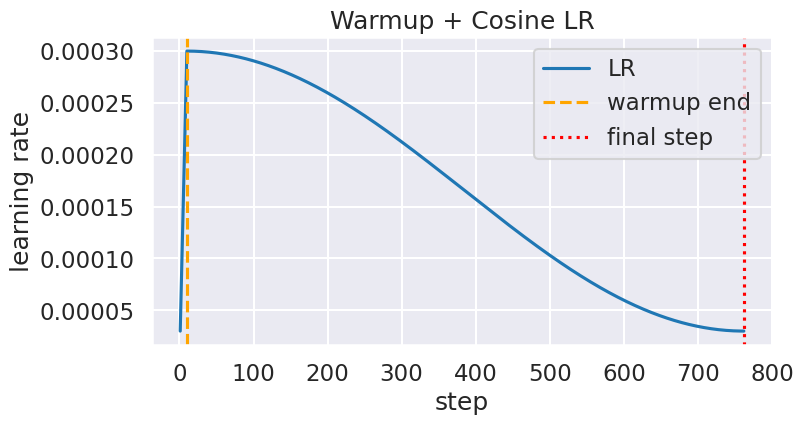

Saved figure: artifacts/train_history-20250828-191350.png


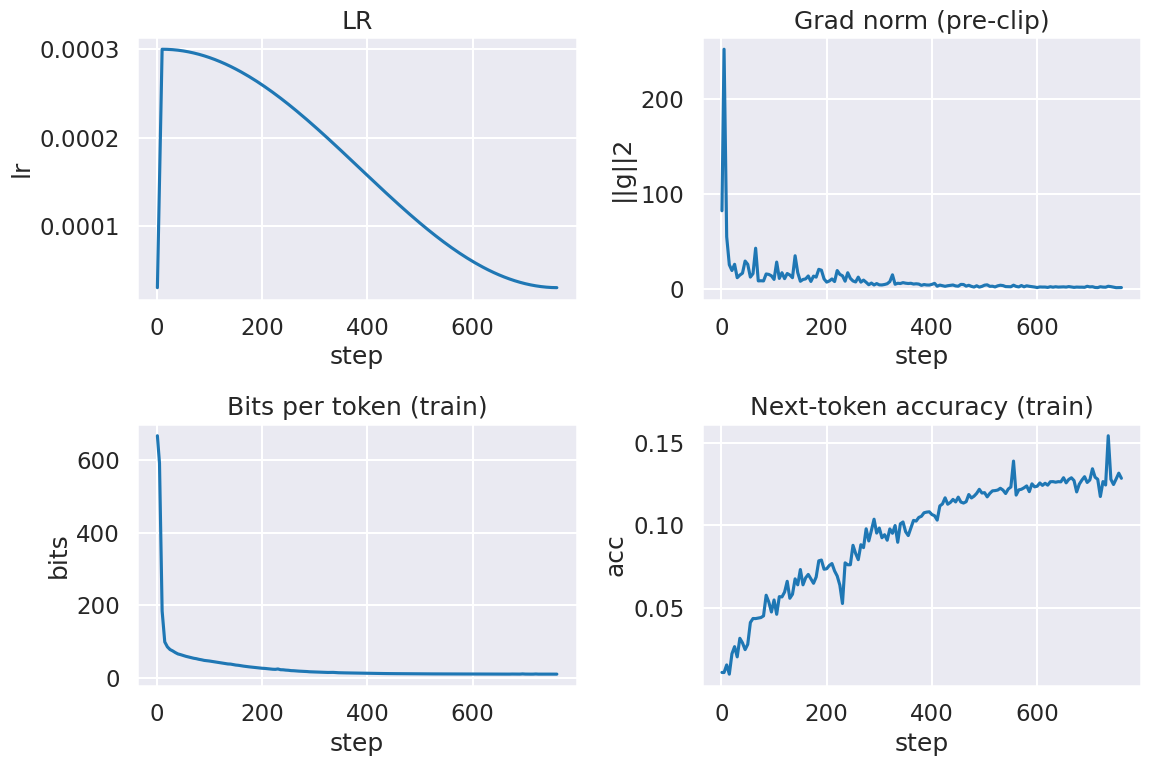

Saved figure: artifacts/val_history-20250828-191350.png


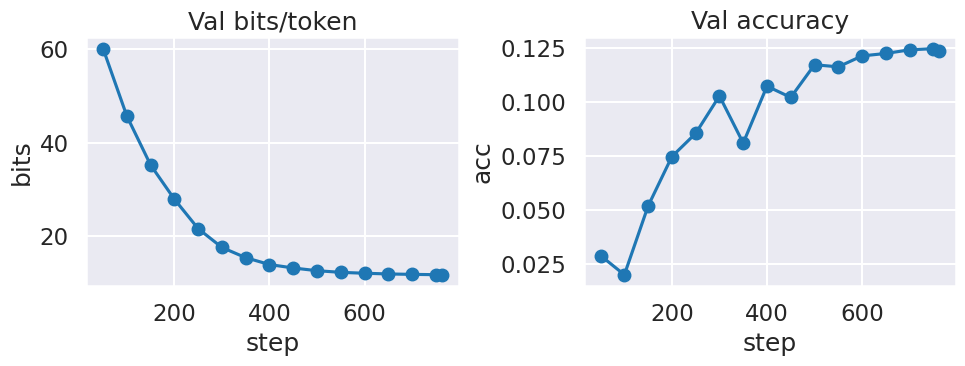

Saved figure: artifacts/loss_by_position_bits-20250828-191350.png


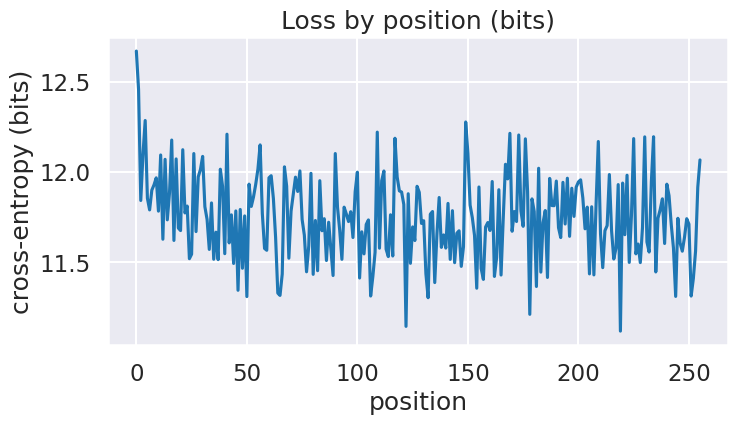

Saved figure: artifacts/attn_distance_overlay-20250828-191350.png


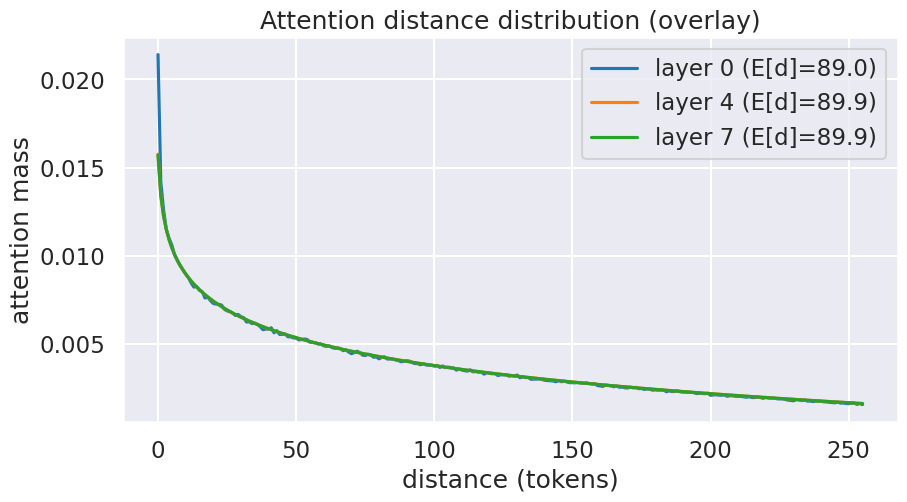

Saved figure: artifacts/bytes_per_token_hist-20250828-191353.png


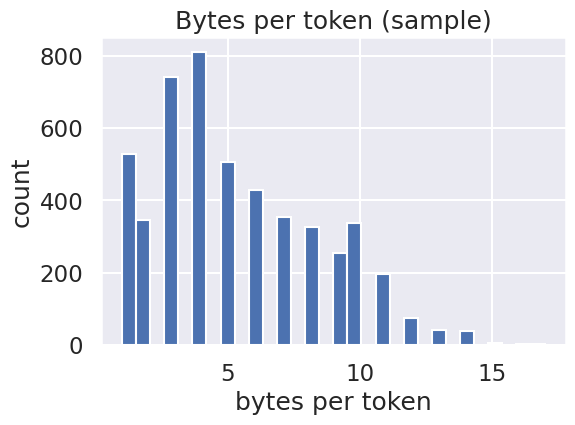



 === Generation === 
The history of machine learning began when.

References
M


 
  || || || || || Leaguean (18.

. 
19 players
The)
L
  

 



The:

D-GGG is the United States
  



 " (aa
  
 in is 2004 

  

Saved generation: artifacts/generation-20250828-191354.txt


In [18]:
# Pretty-print summary and save
print({k: v for k, v in summary.items() if k != "last_val_metrics"})
savejson(summary, "summary")


# LR schedule
fig_lr = plot_lr_schedule(
    cfg, total_steps=total_opt_steps, final_step=summary.get("final_step")
)
savefig(fig_lr, "lr_schedule")
plt.show(fig_lr)

# Train history (if available)
hist = summary.get("history") or {}
fig_hist = plot_train_history(hist)
if fig_hist is not None:
    savefig(fig_hist, "train_history")
    plt.show(fig_hist)

# Val history (if available)
fig_valhist = plot_val_history(hist)
if fig_valhist is not None:
    savefig(fig_valhist, "val_history")
    plt.show(fig_valhist)

# Loss by position (bits)
fig_lbp = plot_loss_by_position(summary.get("last_val_metrics", {}), max_positions=256)
if fig_lbp is not None:
    savefig(fig_lbp, "loss_by_position_bits")
    plt.show(fig_lbp)

# Attention distance overlay
fig_attn = plot_attention_distance_overlay(
    summary.get("last_val_metrics", {}), max_distance=256
)
if fig_attn is not None:
    savefig(fig_attn, "attn_distance_overlay")
    plt.show(fig_attn)

# Bytes per token histogram
fig_bpt = plot_bytes_per_token_hist(val_loader, tokenizer, bins=30, max_tokens=5000)
if fig_bpt is not None:
    savefig(fig_bpt, "bytes_per_token_hist")
    plt.show(fig_bpt)

# Text generation sanity check
PROMPT = "The history of machine learning began when"
gen_text = generate_text(
    model,
    tokenizer,
    prompt=PROMPT,
    max_new_tokens=80,
    temperature=0.9,
    top_k=50,
    device=device,
)
print("\n\n === Generation === ")
print(gen_text)
gen_path = ARTIFACTS_DIR / f"generation-{_ts()}.txt"
with open(gen_path, "w") as f:
    f.write(gen_text)
print(f"Saved generation: {gen_path}")